### Тестовое задание (предсказание дефолта по займу)

### Григорьев Максим

### Задачи
1. Построить модель предсказания дефолта по кредиту (бинарная классификация)
2. Оценить качество модели: стабильность во времени (не ухудшается ли метрика со временем)
3. Оценить стабильность переменных (PSI - Population Stability Index)

### Обоснование выбора подхода
1. Выбор алгоритма: Логистическая регрессия (LogReg) - интерпретируема, легко интегрируется с WOE.
2. Метрики качества:
    - Основная: Gini - стандарт для кредитного скоринга, учитывает ранжирование рисков
    - Дополнительные: AUC, KS (для разделения классов), PR-AUC (для имбаланса), Brier score (калибровка вероятностей)
3. Валидация: Nested Time-Series Cross-Validation (Rolling Window) - данные временные (по месяцам), чтобы избежать утечек и оценить стабильность во времени
    - Внешний цикл: Оценка обобщающей способности
    - Внутренний цикл: Подбор гиперпараметров
4. Предобработка:
    - Биннинг: OptimalBinning для числовых фич (монотонный биннинг для сохранения интерпретируемости).
    - Кодировка: Weight of Evidence (WOE) - преобразует фичи в лог-отношения, улучшает линейность
    - Отбор фич: Information Value (IV) > 0.02 (стандартный порог для predictive power)
5. Баланс классов: class_weight='balanced' в LogReg.
6. Финал: тренировка на всех данных с лучшими параметрами, сохранение модели (pickle).

In [1]:
# Import core libraries

import warnings
from dataclasses import dataclass, field

import chardet
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders.woe import WOEEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from optbinning import OptimalBinning
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, roc_curve, classification_report, log_loss
from sklearn.model_selection import RandomizedSearchCV, ParameterSampler
from tqdm.auto import tqdm

warnings.filterwarnings(
    "ignore",
    message=".*force_all_finite.*",
    category=FutureWarning,
    module="sklearn"
)

np.random.seed(42)

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

### Data loading & QC (raw check)

- Проверка формата, кодировки, дубликатов, типов данных
- Первичный просмотр: head(), info(), describe()
- Проверка распределения target (bad rate), баланса классов
- Быстрый антиутечечный скрининг: подозрительные признаки (высокая корреляция с target)

In [2]:
# Verify the file encoding before loading
with open("Data_ТЗ МЛ.txt", "rb") as f:
    rawdata = f.read(50000)
chardet.detect(rawdata)


{'encoding': 'windows-1251',
 'confidence': 0.9088887998873629,
 'language': 'Russian'}

In [3]:
# Load the data and display it
df = pd.read_csv("Data_ТЗ МЛ.txt", sep=";", encoding="windows-1251")
df.head()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка,Флаг дефолта по кредиту
0,1,7000,12,39,Мужской,Среднее специальное,Мобильные телефоны,Детей нет,Другие регионы,21000,Другое,МТС,Не клиент банка,Нет дефолта
1,1,19000,6,20,Мужской,Среднее специальное,Бытовая техника,Дети есть,Другие регионы,17000,Другое,Теле2,Клиент банка,Нет дефолта
2,1,29000,12,23,Женский,Среднее специальное,Бытовая техника,Детей нет,Другие регионы,31000,Другое,Билайн,Не клиент банка,Нет дефолта
3,1,10000,12,30,Мужской,Среднее специальное,Мобильные телефоны,Дети есть,Другие регионы,31000,Никогда не был(а) женат/замужем,Теле2,Клиент банка,Нет дефолта
4,1,14500,12,25,Женский,Высшее,Мобильные телефоны,Детей нет,Другие регионы,26000,Женат/замужем,МТС,Клиент банка,Нет дефолта


In [4]:
# Inspect the dataset and identify missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Месяц выдачи кредита        1723 non-null   int64 
 1   Сумма кредита               1723 non-null   int64 
 2   Срок кредита                1723 non-null   int64 
 3   Возраст клиента             1723 non-null   int64 
 4   Пол клиента                 1723 non-null   object
 5   Образование клиента         1723 non-null   object
 6   Тип товара                  1723 non-null   object
 7   Наличие детей у клиента     1723 non-null   object
 8   Регион выдачи кредита       1723 non-null   object
 9   Доход клиента               1723 non-null   int64 
 10  Семейное положение          1723 non-null   object
 11  Оператор связи              1723 non-null   object
 12  Является ли клиентом банка  1723 non-null   object
 13  Флаг дефолта по кредиту     1723 non-null   obje

In [5]:
# Count and display duplicate rows
duplicate_rows = df[df.duplicated()]
df = df.drop_duplicates()
print(f"Total number of duplicate rows: {duplicate_rows.shape[0]}")

Total number of duplicate rows: 0


In [6]:
# Rename columns to English-friendly names
df.rename(columns={
    "Месяц выдачи кредита": "month",
    "Сумма кредита": "loan_amount",
    "Срок кредита": "loan_term",
    "Возраст клиента": "age",
    "Пол клиента": "gender",
    "Образование клиента": "education",
    "Тип товара": "product",
    "Наличие детей у клиента": "children",
    "Регион выдачи кредита": "region",
    "Доход клиента": "income",
    "Семейное положение": "marital_status",
    "Оператор связи": "mobile_operator",
    "Является ли клиентом банка": "is_bank_client",
    "Флаг дефолта по кредиту": "target"
}, inplace=True)

df.columns = df.columns.str.strip()

print(f"New columns: \n{'\n'.join(df.columns.tolist())}")

New columns: 
month
loan_amount
loan_term
age
gender
education
product
children
region
income
marital_status
mobile_operator
is_bank_client
target


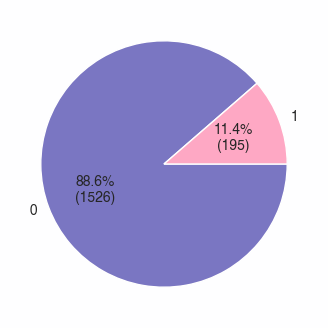

In [7]:
# Target -> binary
target_map = {"Дефолт": 1, "Нет дефолта": 0}
df["target"] = df["target"].map(target_map).astype(int)

# Visualize the distribution of the target variable
fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(
    x=df["target"].value_counts().values,
    labels=df["target"].value_counts().index,
    autopct=lambda p: f"{p:1.1f}%\n({int(p * sum(df["target"].value_counts().values) / 100)})",
    counterclock=False
)
plt.show()

In [8]:
# Convert object columns to category (saves memory, useful for categorical features)
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype("category")

# Convert all numeric columns except 'target' to float (ensures consistency for calculations)
for col in df.select_dtypes(include=[np.number]).columns:
    if col not in ["target", "month"]:
        df[col] = df[col].astype(float)

In [9]:
# Simple leakage screening: detect suspicious features that might leak target
def leakage_check(df, target="target"):
    suspicious = []

    # Numeric features: check correlation
    for c in df.select_dtypes("number").drop(columns=target, errors="ignore"):
        corr = df[c].corr(df[target])
        if abs(corr) > 0.2:
            suspicious.append(f"{c}: corr={corr:.3f}")

    # Categorical features: check bad rate extremes
    for c in df.select_dtypes("category"):
        br = df.groupby(c, observed=True)[target].mean()
        if br.max() > 0.95 or br.min() < 0.05:
            suspicious.append(f"{c}: bad_rate range = [{br.min():.2f}, {br.max():.2f}]")

    return suspicious


print("Suspicious features:\n  ", "\n   ".join(leakage_check(df)))


Suspicious features:
   education: bad_rate range = [0.00, 0.19]
   product: bad_rate range = [0.00, 0.33]


**Выводы**
1. Виден явный `дисбаланс классов` -> взвешивание весов / oversampling
2. Все данные чистые, без пропусков и дубликатов -> сказка просто))) не данных мало(((
2. В фичах `product` и `education` есть небольшой data leakage, вероятно есть категории, полностью разделяющие целевой признак -> более детальный разбор

### PSI - Population Stability Index (drift & stability)
- Расчет PSI по месяцам для каждого признака; агрегации: PSI_max, PSI_mean
- Пороги: 0.1 — слабый сдвиг; 0.25 — action threshold (флаг нестабильности)
- Линейные графики PSI по времени для флагнутых признаков

In [10]:
# PSI between two aligned probability vectors
def psi(p_ref, p_cur, eps=1e-12):
    p_ref = np.clip(np.asarray(p_ref, float), eps, 1)
    p_cur = np.clip(np.asarray(p_cur, float), eps, 1)
    return float(np.sum((p_cur - p_ref) * np.log(p_cur / p_ref)))


In [11]:
# Fixed quantile-based bin edges
def quantile_bin_edges(ref_series, n_bins=10):
    s = pd.to_numeric(ref_series, errors="coerce").dropna()
    if s.empty or s.nunique() < 2:
        return np.array([s.min(), s.max()]) if not s.empty else np.array([0.0, 1.0])

    cats = pd.qcut(s, q=min(n_bins, s.nunique()), duplicates="drop")
    edges = np.unique(
        np.r_[cats.cat.categories.left.values[0], cats.cat.categories.right.values]
    )
    return edges

In [12]:
# Compute per-month PSI for each feature vs. reference window
def get_psi_matrix(df, n_bins=10):
    all_feats = [c for c in df.columns if c not in ["month", "target"]]
    num_feats = df[all_feats].select_dtypes(include=[np.number]).columns.tolist()
    cat_feats = [c for c in all_feats if c not in num_feats]

    # Months and reference window
    months = np.sort(df["month"].unique())
    is_ref = df["month"].isin(months[:4])

    # Pre-group by month to avoid repeated filtering
    g_by_month = {m: grp for m, grp in df.groupby("month", sort=False, observed=True)}

    psi_by_feat = []

    # Numeric features
    for col in num_feats:
        ref_vals = df.loc[is_ref, col]
        edges = quantile_bin_edges(ref_vals, n_bins=n_bins)

        # Degenerate edges -> PSI = 0 for all months
        if len(edges) < 2 or not np.isfinite(edges).all() or np.allclose(edges[0], edges[-1]):
            psi_by_feat.append(pd.Series({m: 0.0 for m in months}, name=col))
            continue

        # Reference distribution
        ref_binned = pd.cut(ref_vals, bins=edges, include_lowest=True)
        bins_order = ref_binned.cat.categories
        ref_p = ref_binned.value_counts(normalize=True, sort=False)

        # Monthly PSI
        month_psi = {}
        for m in months:
            cur_vals = g_by_month[m][col]
            cur_binned = pd.cut(cur_vals, bins=edges, include_lowest=True)
            cur_p = cur_binned.value_counts(normalize=True, sort=False).reindex(bins_order, fill_value=0.0)
            month_psi[m] = psi(ref_p.values, cur_p.values)

        psi_by_feat.append(pd.Series(month_psi, name=col))

    # Categorical features
    for col in cat_feats:
        ref_levels = df.loc[is_ref, col].astype("object")
        ref_p = ref_levels.value_counts(normalize=True)

        month_psi = {}
        for m in months:
            cur_levels = g_by_month[m][col].astype("object")
            levels = ref_p.index.union(cur_levels.value_counts().index)
            ref_vec = ref_p.reindex(levels, fill_value=0.0).values
            cur_vec = cur_levels.value_counts(normalize=True).reindex(levels, fill_value=0.0).values
            month_psi[m] = psi(ref_vec, cur_vec)

        psi_by_feat.append(pd.Series(month_psi, name=col))

    psi_matrix = pd.concat(psi_by_feat, axis=1)
    psi_matrix.index.name = "month"
    return psi_matrix


In [13]:
# Plots of monthly PSI for features with PSI_max >= threshold
def plot_unstable_features(psi_matrix, psi_summary, threshold=0.25):
    flagged = psi_summary.index[psi_summary["PSI_max"] >= threshold].tolist()
    if not flagged:
        print("No unstable features above threshold.")
        return

    for feat in flagged:
        plt.figure(figsize=(5, 3))
        y = psi_matrix[feat]
        plt.plot(psi_matrix.index, y, marker="o")
        plt.axhline(0.1, linestyle="--", linewidth=1)  # mild shift guideline
        plt.axhline(0.25, linestyle="--", linewidth=1)  # action threshold
        plt.title(f"Monthly PSI — {feat}")
        plt.xlabel(psi_matrix.index.name or "month")
        plt.ylabel("PSI")
        plt.tight_layout()
        plt.show()


In [14]:
# Aggregate statistics
psi_matrix = get_psi_matrix(df, n_bins=10)
psi_max = psi_matrix.max(axis=0).rename("PSI_max")
psi_mean = psi_matrix.mean(axis=0).rename("PSI_mean")

# Summary table
psi_summary = pd.concat([psi_max, psi_mean], axis=1).sort_values("PSI_max", ascending=False)

# Flag features with high PSI (commonly ≥ 0.25)
psi_summary["Flagged"] = psi_summary["PSI_max"] >= 0.25
psi_summary

,PSI_max,PSI_mean,Flagged
product,1.437096,0.726381,True
education,0.505188,0.143949,True
mobile_operator,0.360724,0.111308,True
is_bank_client,0.132447,0.019112,False
income,0.123582,0.070014,False
loan_amount,0.117282,0.069470,False
loan_term,0.103664,0.046809,False
age,0.093139,0.054696,False
gender,0.060468,0.012439,False
children,0.035873,0.006901,False


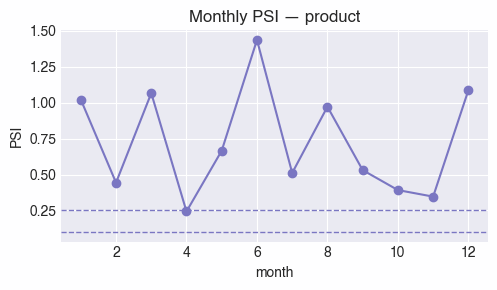

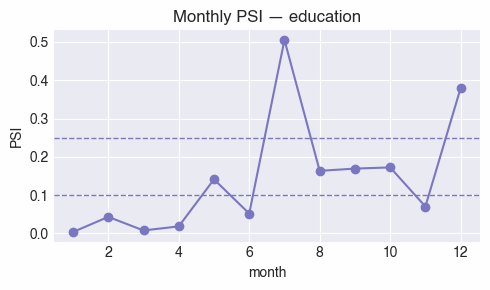

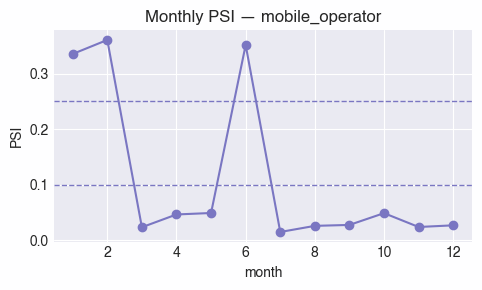

In [15]:
plot_unstable_features(psi_matrix, psi_summary)

**Выводы**
1. `Product` - **PSI_max = 1.10, PSI_mean = 0.72** -> это ужасный уровень дрейфа -> попробовать укрупнить категорию иначе исключить
2. `Education` - **PSI_max = 0.50, PSI_mean = 0.14** -> нестабильный, хотя средний дрейф умеренный -> укрупнить категории
3. `mobile_operator` - в целом стабилен, но есть два эпизода резкого дрейфа
4. Виден месячный дрейф распределений -> необходимо использовать time-based split вместо случайного разбиения.

### Data split
- Определение стратегии: time-based split (rolling CV) + последний месяц OOT из-за месячного дрейфа
- Разделение по принципу no leakage

In [16]:
# sort + list months + last two months for OOT
df = df.sort_values("month").reset_index(drop=True)
months = np.sort(df["month"].unique())
oot_month = months[-1:]

# Train (everything except last two months) and OOT
df_train = df[~df["month"].isin(oot_month)].copy()
df_oot = df[df["month"].isin(oot_month)].copy()

print(f"Train shape : {df_train.shape} | Train months : {months[:-1].tolist()}")
print(f"OOT shape   : {df_oot.shape}  | OOT months   : {oot_month.tolist()}")


Train shape : (1561, 14) | Train months : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
OOT shape   : (162, 14)  | OOT months   : [12]


In [17]:
# Rolling CV generator (train = all months < m, valid = month m)
def month_rolling_splits(data: pd.DataFrame):
    ms = np.sort(data["month"].unique())
    for i in range(4, len(ms)):
        train_months = ms[:i]
        valid_month = ms[i]
        train_idx = data.index[data["month"].isin(train_months)].to_numpy()
        valid_idx = data.index[data["month"] == valid_month].to_numpy()
        yield train_idx, valid_idx, train_months, valid_month


In [18]:
# Quick preview of folds
for k, (tr_idx, va_idx, tr_m, va_m) in enumerate(month_rolling_splits(df_train), 1):
    print(f"Fold {k}: train months {tr_m[0]} - {tr_m[-1]}  | valid month {va_m:2d}  "
          f"| sizes: train={len(tr_idx)}, valid={len(va_idx)}")


Fold 1: train months 1 - 4  | valid month  5  | sizes: train=566, valid=116
Fold 2: train months 1 - 5  | valid month  6  | sizes: train=682, valid=122
Fold 3: train months 1 - 6  | valid month  7  | sizes: train=804, valid=145
Fold 4: train months 1 - 7  | valid month  8  | sizes: train=949, valid=142
Fold 5: train months 1 - 8  | valid month  9  | sizes: train=1091, valid=136
Fold 6: train months 1 - 9  | valid month 10  | sizes: train=1227, valid=160
Fold 7: train months 1 - 10  | valid month 11  | sizes: train=1387, valid=174


**Выводы**
1. Стратификация по target для валидации; для OOT — без стратификации (реалистичность)
2. Баланс классов: class weights / oversampling только в train, не применять к val/test

### EDA (Exploratory Data Analysis)
- Понять качество и структуру данных, найти аномалии и выбросы
- Решить, какие признаки оставить/удалить/трансформировать
- Сформировать гипотезы для feature engineering

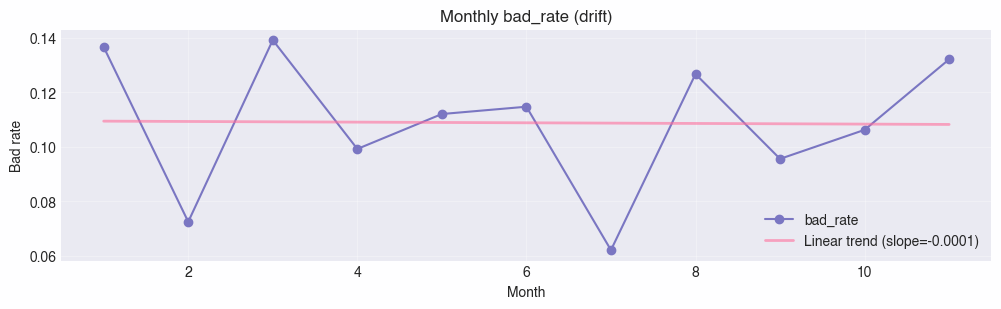

In [19]:
# Simple EDA: bad_rate dynamics, trend
monthly = (
    df_train.groupby("month", observed=True)["target"].agg(n="count", bad="sum",
                                                           bad_rate="mean").reset_index().sort_values("month")
)
coef = np.polyfit(np.arange(len(monthly)), monthly["bad_rate"].values, 1)
trend = np.polyval(coef, np.arange(len(monthly)))

plt.figure(figsize=(12, 3))
plt.plot(monthly["month"], monthly["bad_rate"], marker="o", label="bad_rate")
plt.plot(monthly["month"], trend, linewidth=2, label=f"Linear trend (slope={coef[0]:.4f})")
plt.title("Monthly bad_rate (drift)")
plt.xlabel("Month")
plt.ylabel("Bad rate")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

**Выводы**
1. `Drift`: есть месяцы с резким падением и пиком -> вероятно сезонность
2. `Trend`: отрицательный наклон -> в среднем дефолтность падает со временем -> out-of-time тест обязателен

In [20]:
def plot_categorical_eda(df: pd.DataFrame, cat_cols: list):
    df_cat = df.copy()

    for c in cat_cols:
        df_cat[c] = df_cat[c].astype("object")

    psi_matrix = get_psi_matrix(df_cat[["month", "target"] + cat_cols])

    for col in cat_cols:
        vc = df[col].value_counts(dropna=False)
        pd_by_level = df.groupby(col, observed=True)["target"].mean().sort_values(ascending=False)
        psi_series = psi_matrix[col]

        fig, axes = plt.subplots(1, 3, figsize=(15, 3))
        fig.suptitle(f"Categorical EDA — {col}", y=1.02)
        labels = [str(x)[:7] + "…" if len(str(x)) > 7 else str(x) for x in vc.index]

        # Align both on the same set of categories
        levels = vc.index.union(pd_by_level.index)
        vc = vc.reindex(levels, fill_value=0)
        pd_by_level = pd_by_level.reindex(levels, fill_value=0)

        # Labels (truncate long names)
        labels = [str(x)[:7] + "…" if len(str(x)) > 7 else str(x) for x in levels]

        # Panel 1: Frequency
        axes[0].barh(labels, vc.values)
        axes[0].set_title("Frequency")
        axes[0].invert_yaxis()
        axes[0].grid(True, axis="x", alpha=0.2)

        # Panel 2: PD by level
        axes[1].barh(labels, pd_by_level.values)
        axes[1].set_title("PD by level")
        axes[1].invert_yaxis()
        axes[1].grid(True, axis="x", alpha=0.2)

        # Panel 3: Monthly PSI
        months_sorted = np.sort(df["month"].unique())
        axes[2].plot(months_sorted, psi_series.reindex(months_sorted).values, marker="o")
        axes[2].axhline(0.10, linestyle="--", linewidth=1)  # легкий дрейф
        axes[2].axhline(0.25, linestyle="--", linewidth=1)  # action threshold
        axes[2].set_title(f"Monthly PSI vs first 3 months")
        axes[2].set_xlabel("month")
        axes[2].set_ylabel("PSI")
        axes[2].grid(True, alpha=0.2)

        plt.tight_layout()
        plt.show()

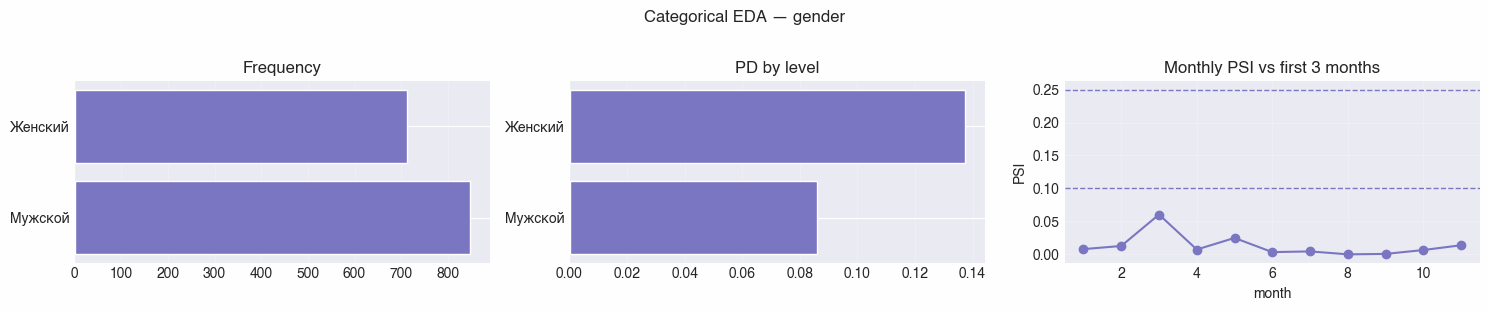

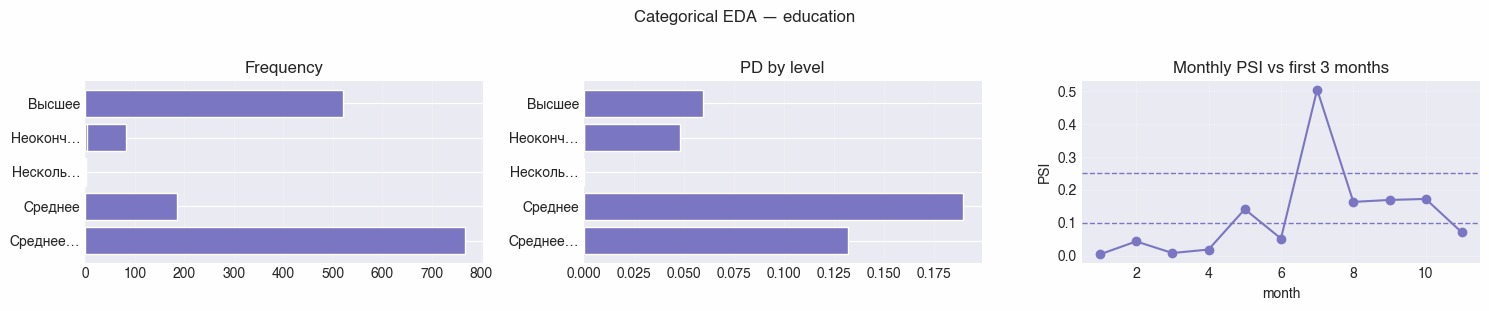

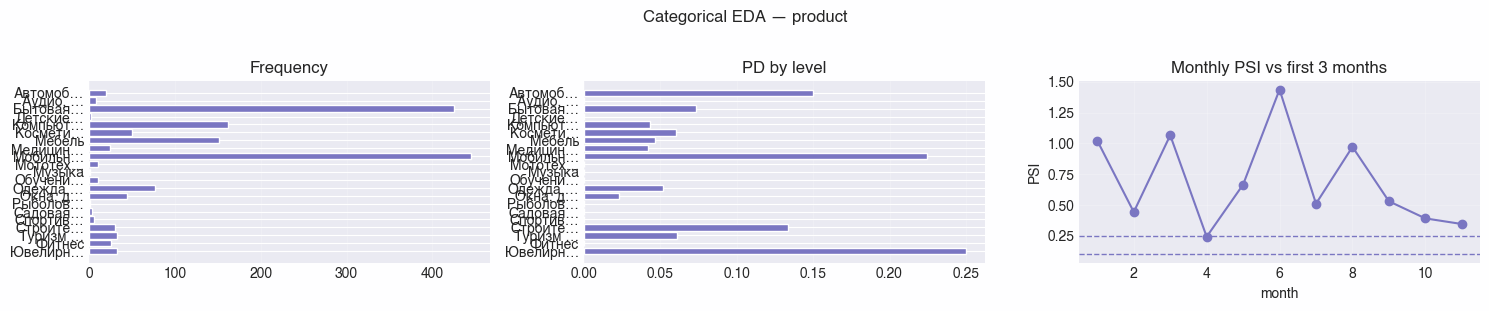

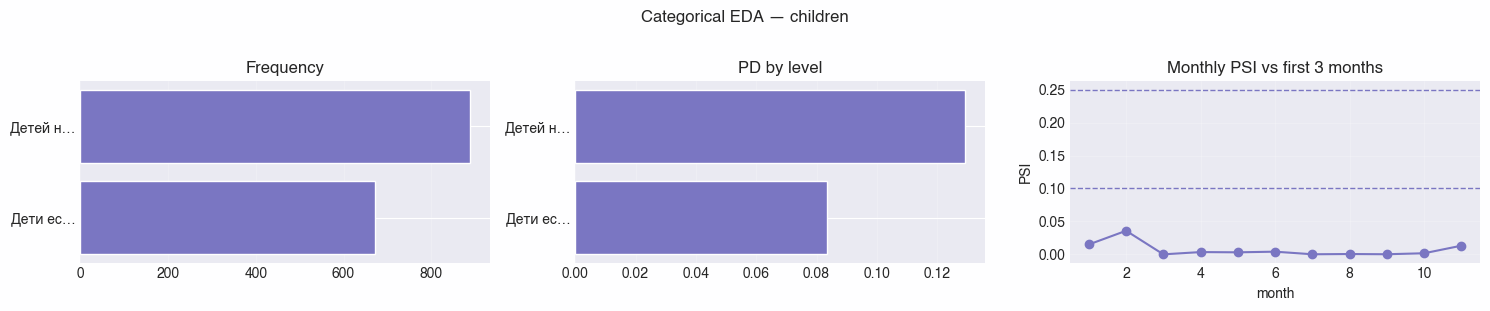

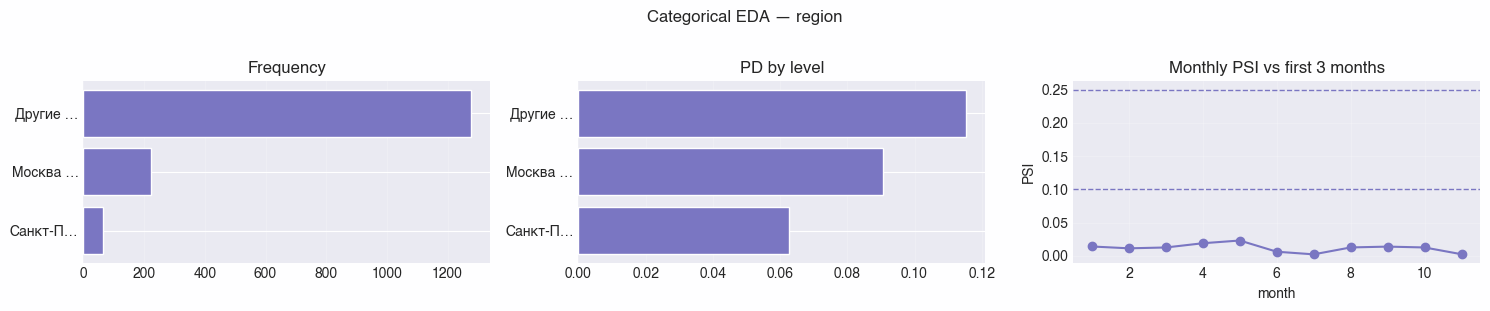

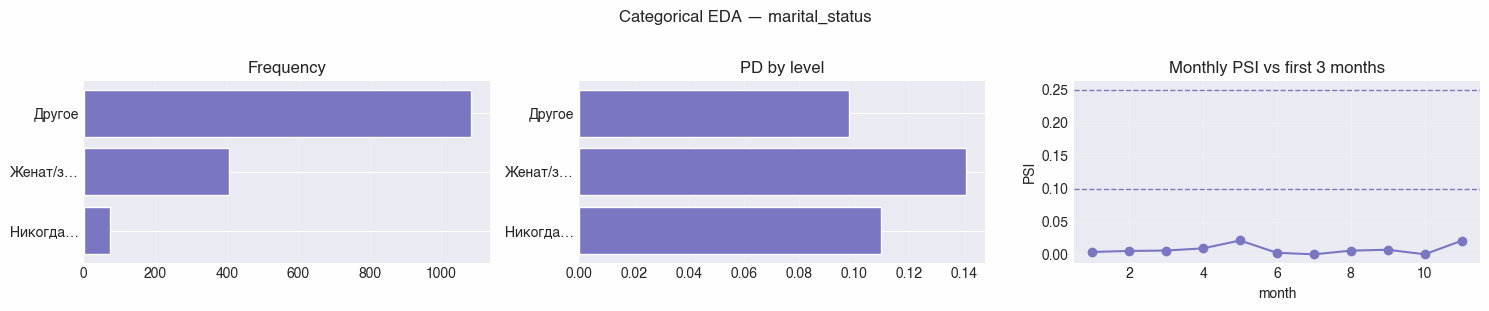

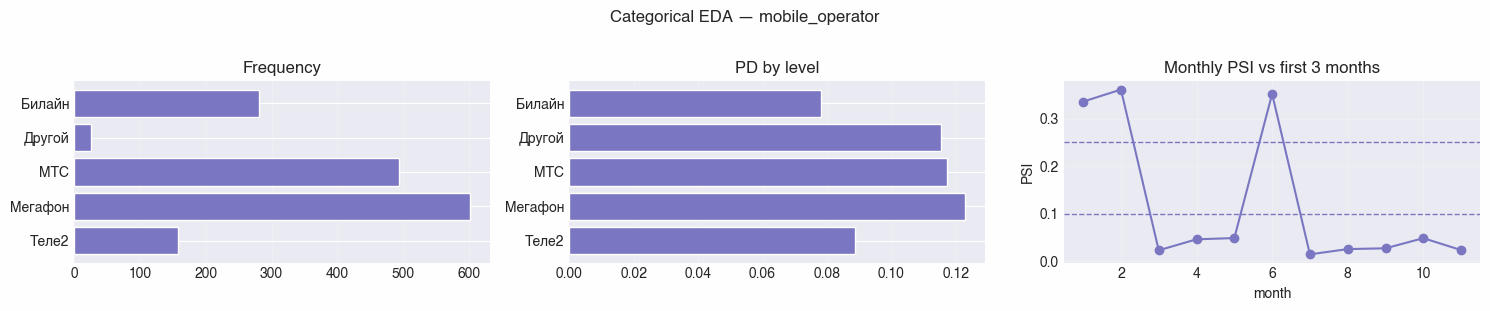

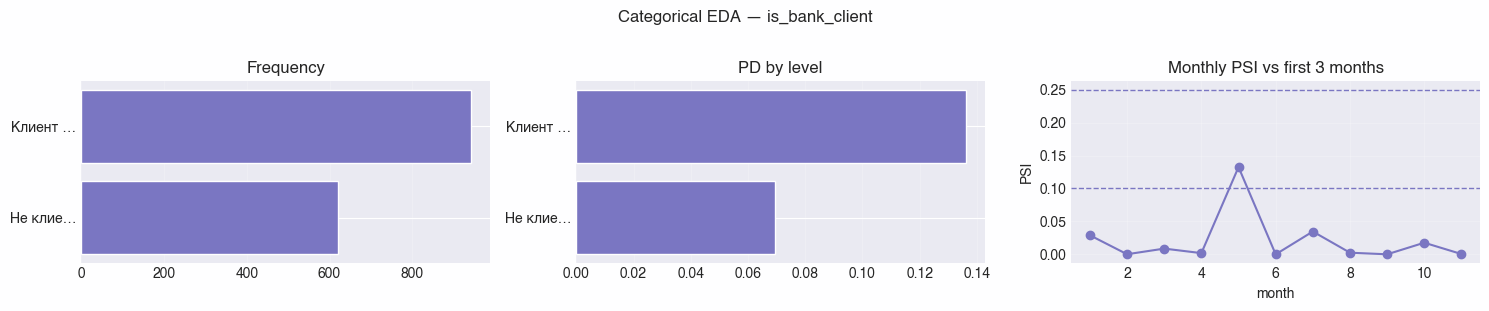

In [21]:
plot_categorical_eda(df_train, df.select_dtypes(include=["object", "category"]).columns.tolist())

**Выводы**
1. Сильные признаки: education, product, is_bank_client, gender
2. Средние признаки: children, material_status
3. Слабые признаки: mobile_operator (почти не дает разделения)
4. Проблема редких категорий: у `product` и `education` есть категории с маленьким числом клиентов

In [22]:
def plot_numeric_eda(df: pd.DataFrame, num_cols: list):
    df_num = df.copy()

    for col in num_cols:
        s = df_num[col].dropna()

        # quantile binning for bad_rate trend
        tmp = df_num[[col, "target"]].copy()
        tmp = tmp.loc[tmp[col].notna()].copy()
        tmp["bin"] = pd.qcut(tmp[col], q=min(s.nunique(), 20), duplicates="drop")

        agg = (
            tmp.groupby("bin", observed=True)["target"]
            .agg(bad_rate="mean", count="size")
            .assign(center=lambda d: d.index.map(lambda iv: iv.mid))
            .sort_values("center")
        )
        p = agg["bad_rate"].clip(1e-9, 1 - 1e-9)
        n = agg["count"].clip(lower=1)
        agg["lo"] = (p - 1.96 * np.sqrt(p * (1 - p) / n)).clip(0, 1)
        agg["hi"] = (p + 1.96 * np.sqrt(p * (1 - p) / n)).clip(0, 1)

        fig, axes = plt.subplots(1, 3, figsize=(15, 3))
        fig.suptitle(f"Numeric EDA — {col}", y=1.02)

        # Panel 1: distribution + KDE + target overlay
        sns.histplot(df_num, x=col, bins=20, stat="density", alpha=0.35, edgecolor=None, ax=axes[0])
        sns.kdeplot(df_num[col], ax=axes[0], linewidth=2)
        sns.kdeplot(data=df_num, x=col, hue="target", common_norm=False, ax=axes[0], linewidth=1.4, alpha=0.9)
        axes[0].set_title("Distribution")
        axes[0].grid(True, alpha=0.2)

        # Panel 2: boxplot
        sns.boxplot(x=df_num[col], ax=axes[1], orient="h", linewidth=1.0, fliersize=2)
        axes[1].set_title("Boxplot")
        axes[1].grid(True, axis="x", alpha=0.2)

        # Panel 3: bad_rate trend
        axes[2].plot(agg["center"], agg["bad_rate"], marker="o", linewidth=2, label="bad_rate")
        axes[2].fill_between(agg["center"], agg["lo"], agg["hi"], alpha=0.2, step="mid", label="95% CI")
        axes[2].set_title(f"Bad rate vs {col} (quantile trend)")
        axes[2].grid(True, alpha=0.2)
        axes[2].legend()

        plt.tight_layout()
        plt.show()


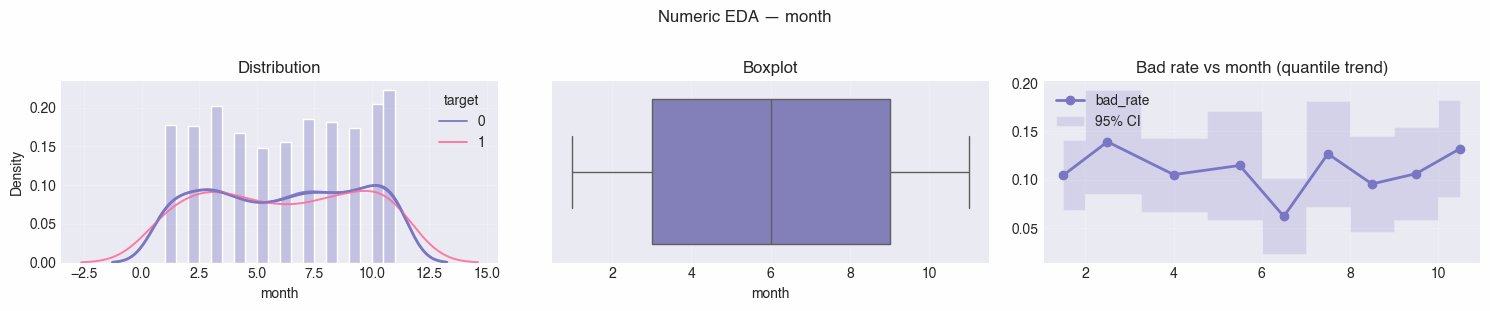

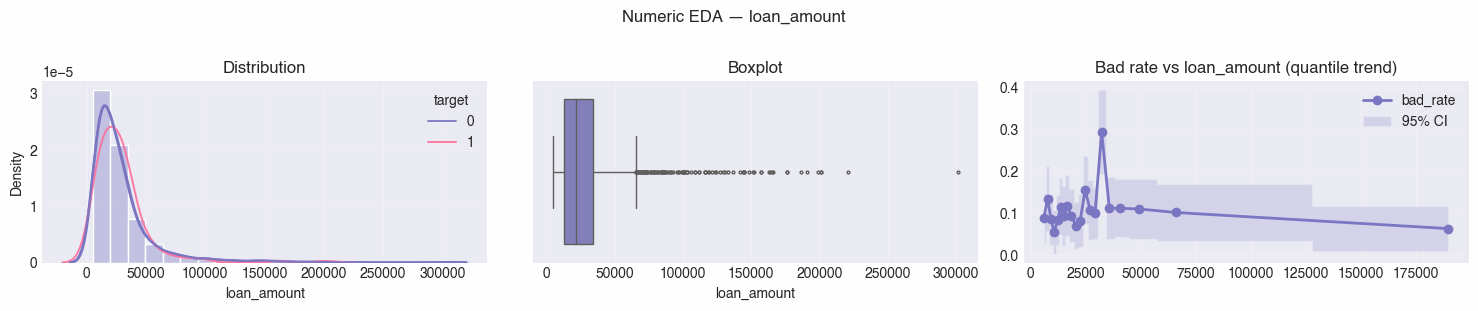

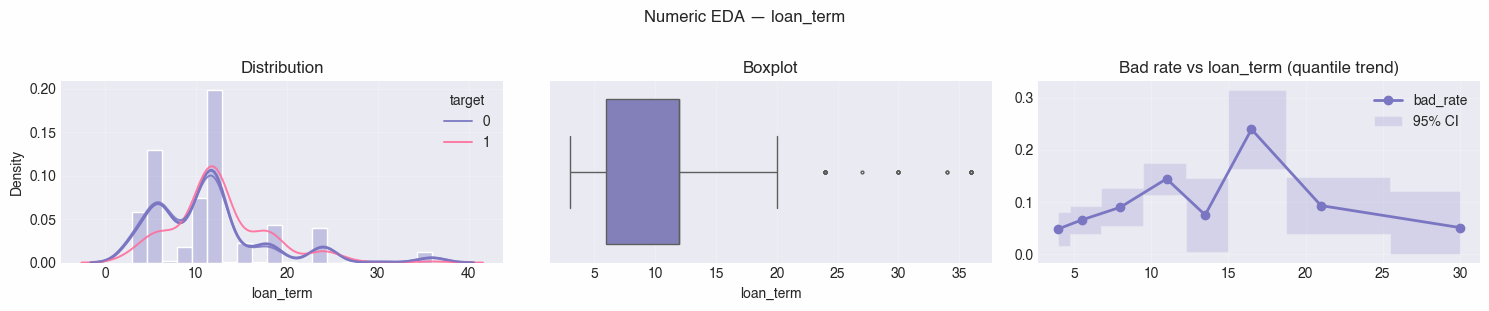

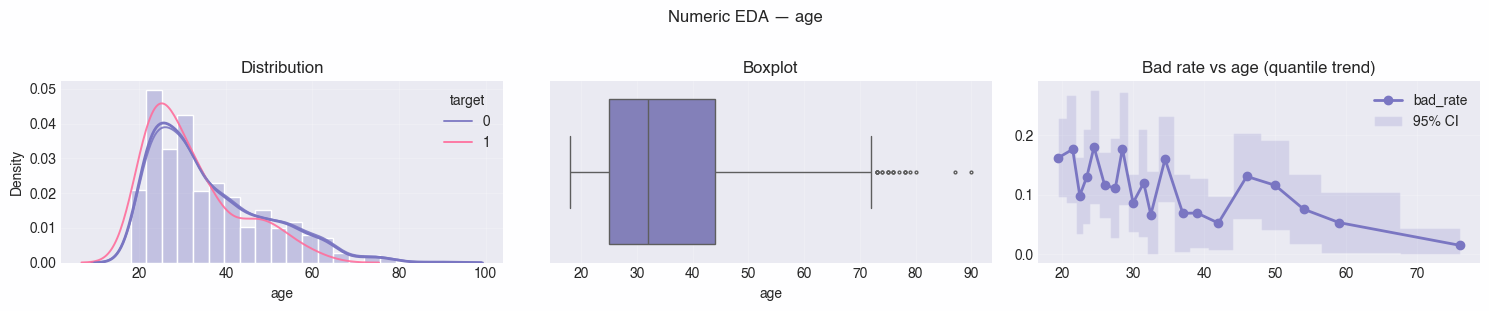

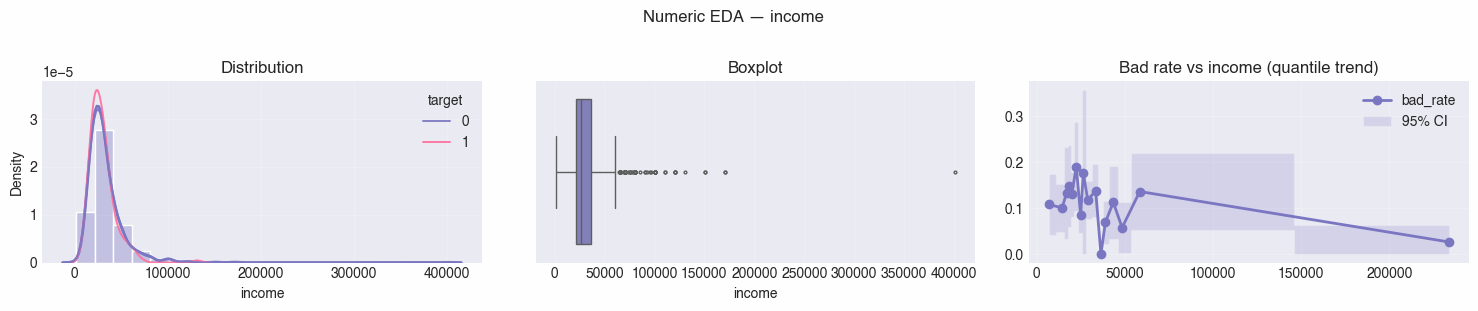

In [23]:
plot_numeric_eda(df_train, df.select_dtypes(include=[np.number]).drop(columns=["target"]).columns.tolist())

**Выводы**
1. `month` — использовать для time-split, но в модель не включать напрямую
2. `loan_amount` — сильный скошенный признак -> винсоризация и биннинги
3. `loan_term` — очень информативный, включать с биннингами
4. `age` — хорошо объясняет риск
5. `income` — один из топовых предикторов -> использовать ratio-производные признаки и винсоризация

### Feature Engineering
- Конструирование новых фич
- Обработка категорий (укрупнение редких)
- Проверка качества признаков

In [24]:
# Look at distribution
print(df_train['product'].value_counts(normalize=True))

product
Мобильные телефоны                                          0.285074
Бытовая техника                                             0.272261
Компьютеры, комплектующие                                   0.103780
Мебель                                                      0.096733
Одежда, изделия из меха и кожи                              0.049327
Косметика и косметические услуги                            0.032031
Окна, двери                                                 0.028187
Туризм и отдых                                              0.021140
Ювелирные украшения                                         0.020500
Строительные материалы и инструменты                        0.019218
Фитнес                                                      0.016015
Медицинские услуги                                          0.015375
Автомобильные товары                                        0.012812
Мототехника (лодки, мото)                                   0.006406
Обучение                  

In [25]:
mapping = {
    # 0. Мобильные телефоны
    "Мобильные телефоны": "Мобильные телефоны",

    # 1. Электроника
    "Бытовая техника": "Электроника",
    "Компьютеры, комплектующие": "Электроника",

    # 2. Дом и мебель
    "Мебель": "Дом и мебель",
    "Окна, двери": "Дом и мебель",
    "Садовая техника": "Дом и мебель",

    # 3. Строительство и ремонт
    "Строительные материалы и инструменты": "Строительство",
    "Строительные и ремонтные услуги": "Строительство",

    # 4. Мода и уход
    "Одежда, изделия из меха и кожи": "Мода и уход",
    "Косметика и косметические услуги": "Мода и уход",
    "Ювелирные украшения": "Мода и уход",

    # 5. Авто и мото
    "Автомобильные товары": "Авто и мото",
    "Мототехника (лодки, мото)": "Авто и мото",
}

cats = list(set(mapping.values())) + ["Другое"]

df_train['product'] = (
    df_train['product'].map(mapping).fillna("Другое").astype(pd.CategoricalDtype(categories=cats))
)

df_oot["product"] = (
    df_oot["product"].map(mapping).fillna("Другое").astype(pd.CategoricalDtype(categories=cats))
)


In [26]:
# Look at distribution
print(df_train['education'].value_counts(normalize=True))

education
Среднее специальное                                       0.490711
Высшее                                                    0.333760
Среднее                                                   0.118514
Неоконченное высшее                                       0.053171
Неоконченное среднее                                      0.002562
Несколько высших или более высокая ступень образования    0.001281
Name: proportion, dtype: float64


In [27]:
mapping = {
    # 1. Среднее специальное
    "Среднее специальное": "Среднее специальное",

    # 2. Высшее
    "Несколько высших или более высокая ступень образования": "Высшее",
    "Высшее": "Высшее",

    # 3. Среднее
    "Среднее": "Среднее",
}

cats = list(set(mapping.values())) + ["Другое"]

df_train["education"] = (
    df_train["education"].map(mapping).fillna("Другое").astype(pd.CategoricalDtype(categories=cats))
)

df_oot["education"] = (
    df_oot["education"].map(mapping).fillna("Другое").astype(pd.CategoricalDtype(categories=cats))
)


In [28]:
# Replace rare categories
def replace_rare_categories(df: pd.DataFrame, column: str, threshold: float = 0.05, other_label: str = "Другое",
                            reference: pd.DataFrame = None):
    ref_df = reference if reference is not None else df
    freqs = ref_df[column].value_counts(normalize=True, dropna=False)
    rare_cats = freqs[freqs < threshold].index

    df_out = df.copy()
    df_out[column] = df_out[column].astype(object)
    df_out[column] = df_out[column].where(~df_out[column].isin(rare_cats), other_label)

    cats = [c for c in freqs.index if c not in rare_cats] + [other_label]
    df_out[column] = df_out[column].astype(pd.CategoricalDtype(categories=cats))
    return df_out


In [29]:
def cross_categories( df: pd.DataFrame, col_1: str, col_2: str, threshold: float = 0.03, other_label: str = "Другое",
                      reference: pd.DataFrame  = None):

    ref = reference if reference is not None else df

    def _prep(s: pd.Series) -> pd.Series:
        return s.astype("string").str.strip().fillna("unknown")

    cross_ref = _prep(ref[col_1]) + " | " + _prep(ref[col_2])
    if 0 < threshold < 1:
        vc = cross_ref.value_counts(normalize=True, dropna=False)
        rare = vc[vc < threshold].index
        base_index = vc.index
    else:
        vc = cross_ref.value_counts(dropna=False)
        rare = vc[vc < int(threshold)].index
        base_index = vc.index

    cross = _prep(df[col_1]) + " | " + _prep(df[col_2])
    cross = cross.where(~cross.isin(rare), other_label)

    known = [c for c in base_index if c not in set(rare)]
    cats = known + ([other_label] if other_label not in known else [])

    df_out = df.copy()
    df_out[f"{col_1} | {col_2}"] = cross.astype(pd.CategoricalDtype(categories=cats))
    return df_out



In [30]:
df_train = cross_categories(df_train, "region", "mobile_operator", threshold=0.025)
df_oot   = cross_categories(df_oot,   "region", "mobile_operator", threshold=0.025, reference=df_train)


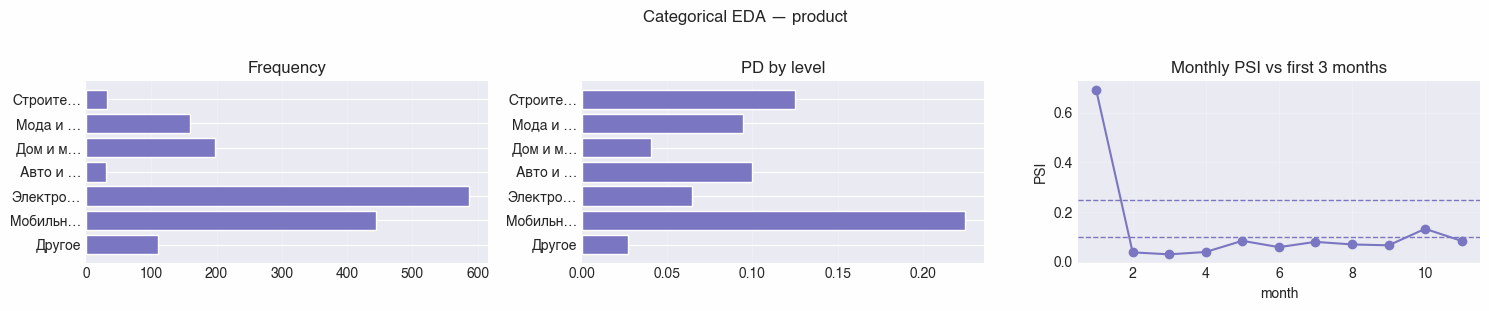

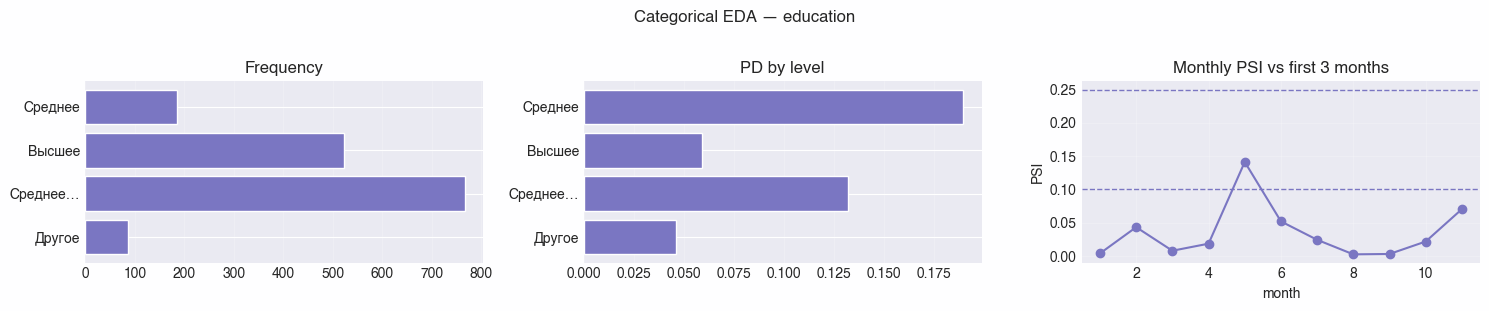

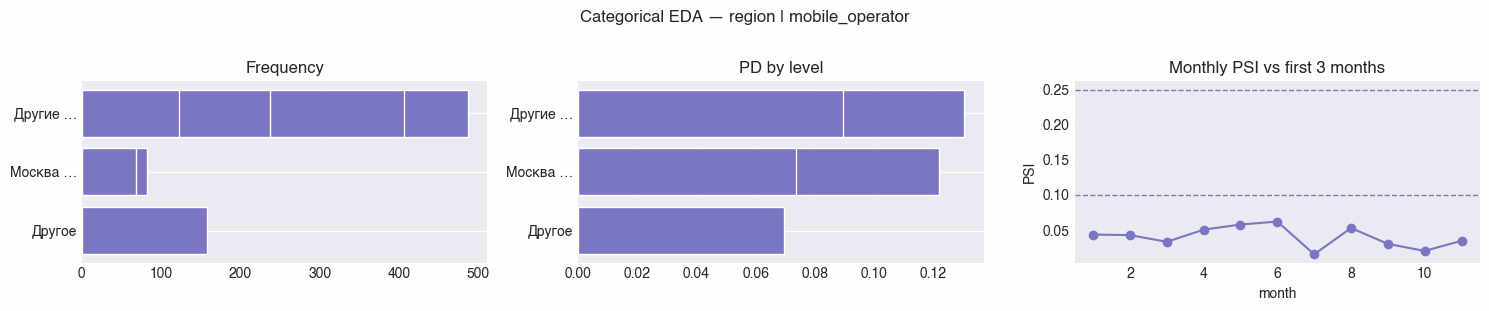

In [31]:
plot_categorical_eda(df_train, ["product", "education", "region | mobile_operator"])

In [32]:
df_train.drop(columns=["mobile_operator"], inplace=True)
df_oot.drop(columns=["mobile_operator"], inplace=True)


**Выводы**
1. Укрупнение категорий (education + product) сильно улучшает стабильность PSI и повышает информативность PD по уровням.
2. `Education` стабильный признак с умеренным влиянием
3. `Product` информативный, но требует мониторинга PSI
4. `region | mobile_operator` стабильный информативный признак

In [33]:
# Winsorize (clip) a numeric column by given quantiles
def winsorize_column(df: pd.DataFrame, column: str, lower_quantile: float = 0.01, upper_quantile: float = 0.99,
                     reference: pd.DataFrame = None):
    ref_df = reference if reference is not None else df
    series = ref_df[column].dropna()

    low = series.quantile(lower_quantile)
    high = series.quantile(upper_quantile)

    df_out = df.copy()
    df_out[column] = np.clip(df_out[column], low, high)
    return df_out


In [34]:
# Winsorize (clip) income & loan_amount
df_train = winsorize_column(df_train, "income", lower_quantile=0.05, upper_quantile=0.93)
df_oot = winsorize_column(df_oot, "income", lower_quantile=0.05, upper_quantile=0.93, reference=df_train)

df_train = winsorize_column(df_train, "loan_amount", lower_quantile=0, upper_quantile=0.93)
df_oot = winsorize_column(df_oot, "loan_amount", lower_quantile=0, upper_quantile=0.93, reference=df_train)

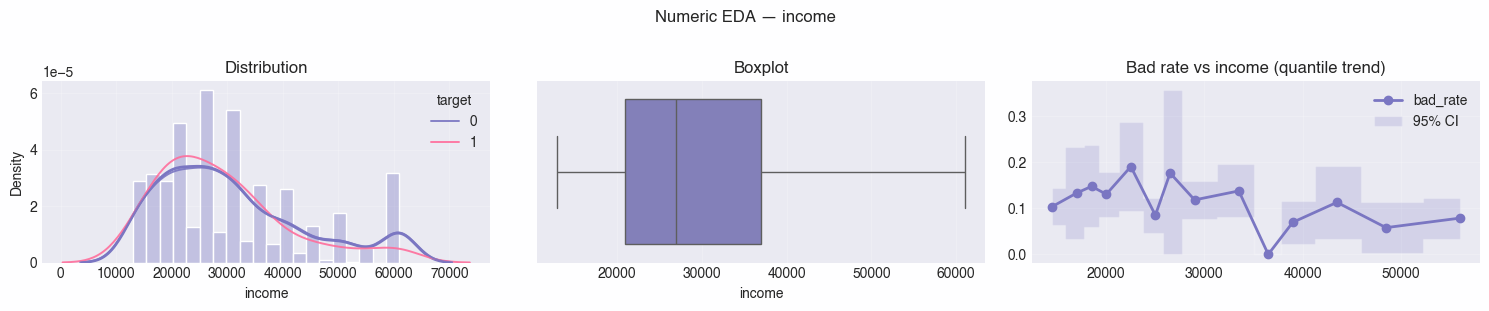

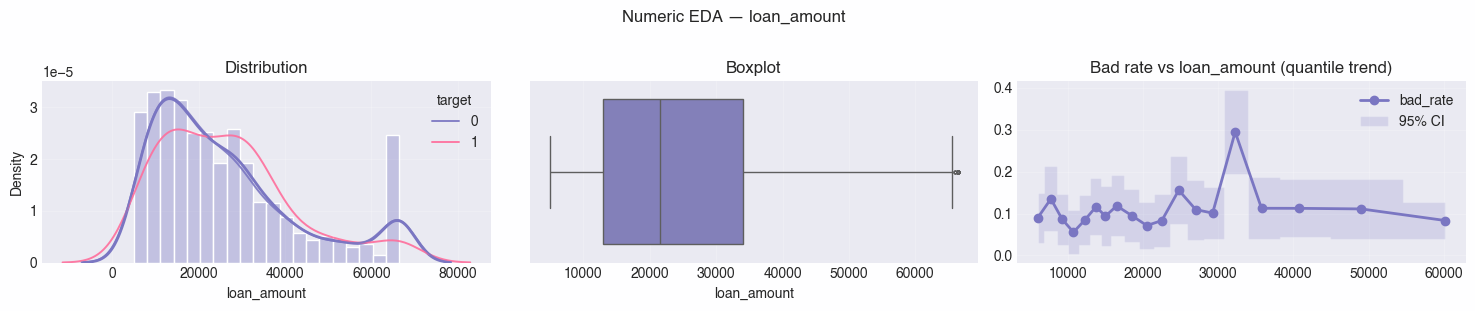

In [35]:
plot_numeric_eda(df_train, ["income", "loan_amount"])

**Выводы**
1. `income` и `loan_amount` в сыром виде были сильно искажены, но после обработки -> распределения стали читаемыми, PD-тренды проявились
2. income выше -> bad_rate ниже
3. loan_amount более 30k -> риск выше, при больших суммах риск снижается

In [36]:
# Create new, hopefully more informative, features
df_train["monthly_payment"] = df_train["loan_amount"].astype(float) / np.clip(df_train["loan_term"].astype(float), 1e-9,
                                                                              None)
df_train["debt_to_income"] = df_train["loan_amount"].astype(float) / np.clip(df_train["income"].astype(float), 1e-9,
                                                                             None)
df_train["payment_to_income"] = df_train["monthly_payment"].astype(float) / np.clip(df_train["income"].astype(float),
                                                                                    1e-9, None)
df_train["loan_to_age"] = df_train["loan_amount"].astype(float) / np.clip(df_train["age"].astype(float), 1e-9, None)
df_train["income_per_age"] = df_train["income"].astype(float) / np.clip(df_train["age"].astype(float), 1e-9, None)

df_oot["monthly_payment"] = df_oot["loan_amount"].astype(float) / np.clip(df_oot["loan_term"].astype(float), 1e-9, None)
df_oot["debt_to_income"] = df_oot["loan_amount"].astype(float) / np.clip(df_oot["income"].astype(float), 1e-9, None)
df_oot["payment_to_income"] = df_oot["monthly_payment"].astype(float) / np.clip(df_oot["income"].astype(float), 1e-9,
                                                                                None)
df_oot["loan_to_age"] = df_oot["loan_amount"].astype(float) / np.clip(df_oot["age"].astype(float), 1e-9, None)
df_oot["income_per_age"] = df_oot["income"].astype(float) / np.clip(df_oot["age"].astype(float), 1e-9, None)

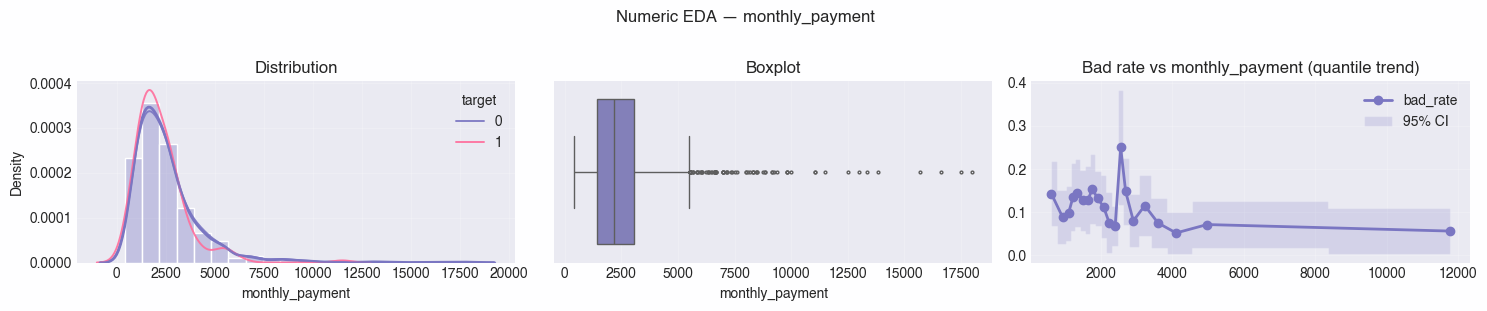

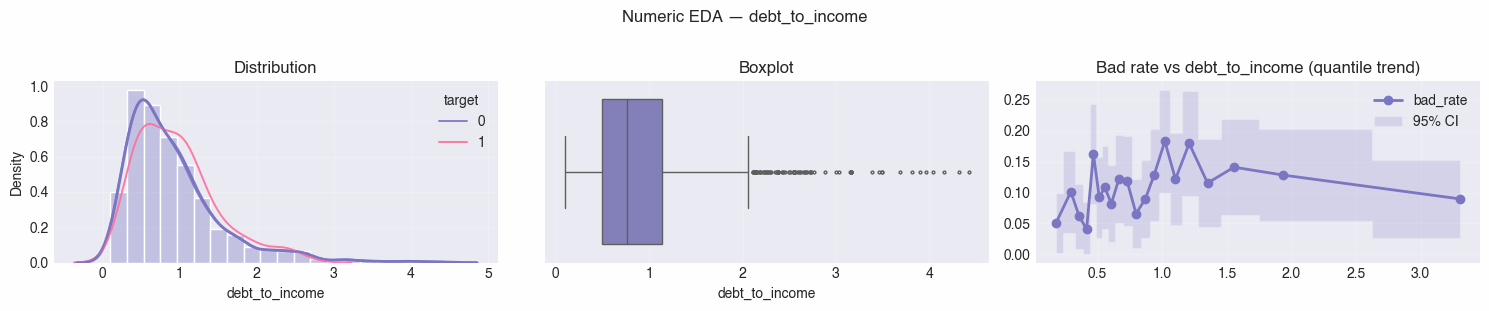

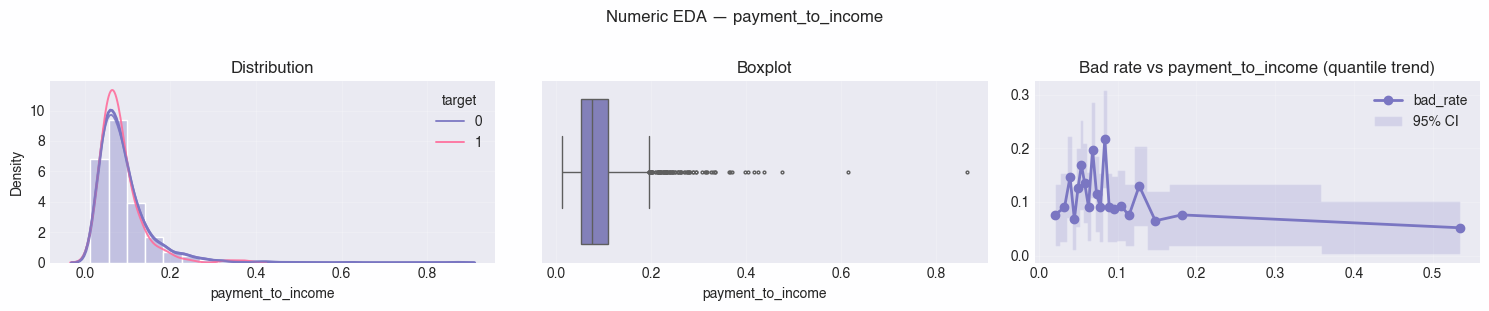

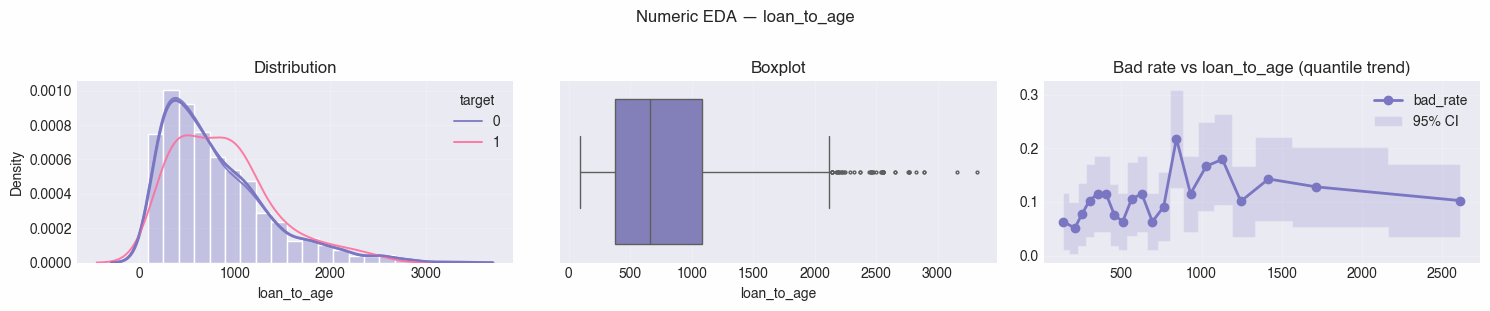

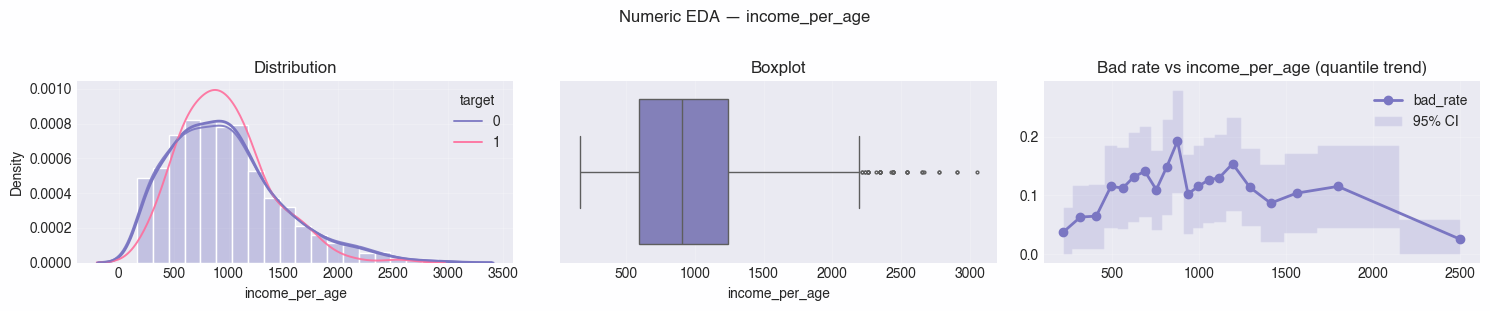

In [37]:
plot_numeric_eda(df_train, ["monthly_payment", "debt_to_income", "payment_to_income", "loan_to_age", "income_per_age"])

 **Выводы**
1. Наиболее информативные признаки:
    - monthly_payment (сильная обратная связь с дефолтом)
    - debt_to_income (классический риск-фактор)
    - payment_to_income (нормализованная версия, компактнее)
2. Вспомогательные признаки:
    - loan_to_age и income_per_age могут давать дополнительные нелинейные сигналы
3. Проблемы: длинные хвосты -> winsorize (log трансформация не лучше, так как WOE сам по себе справляется с нелинейностью)

In [38]:
# Winsorize new features
for col in ["monthly_payment", "debt_to_income", "payment_to_income", "loan_to_age", "income_per_age"]:
    df_train = winsorize_column(df_train, col, lower_quantile=0.03, upper_quantile=0.95)
    df_oot = winsorize_column(df_oot, col, lower_quantile=0.03, upper_quantile=0.95, reference=df_train)

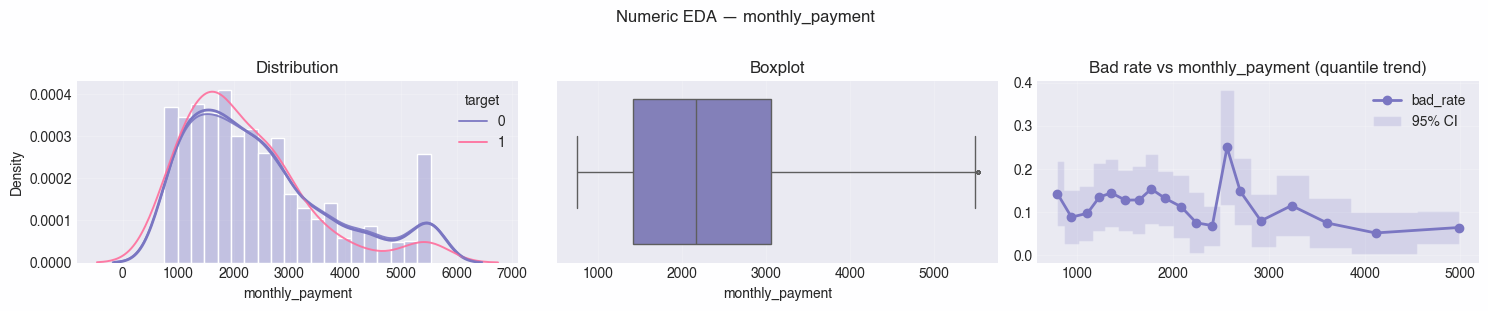

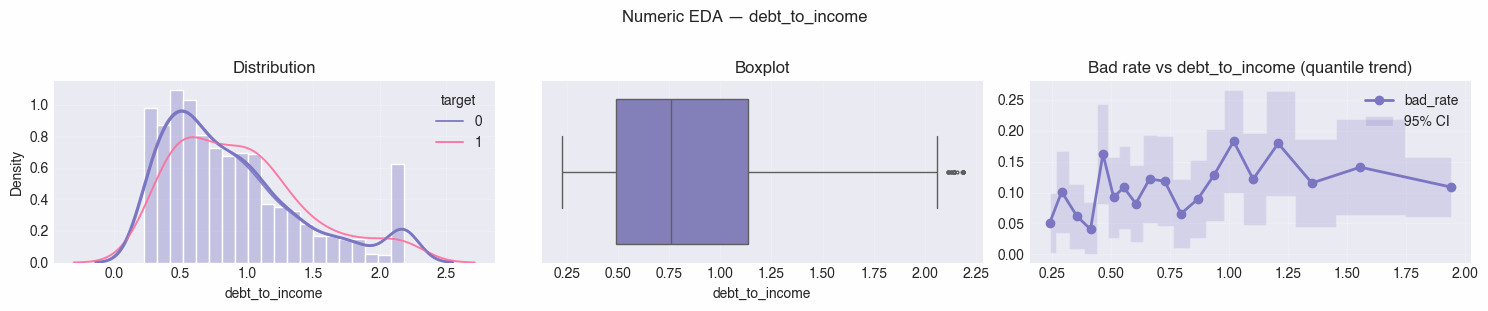

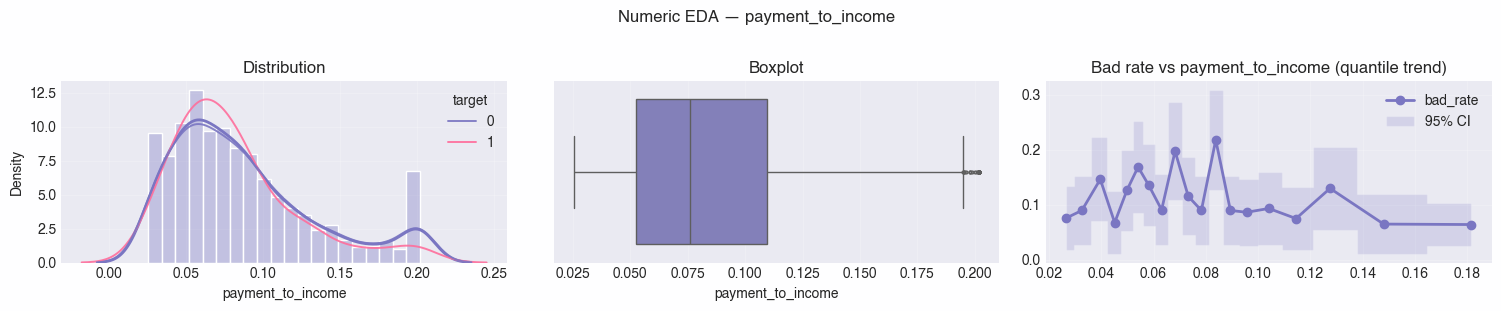

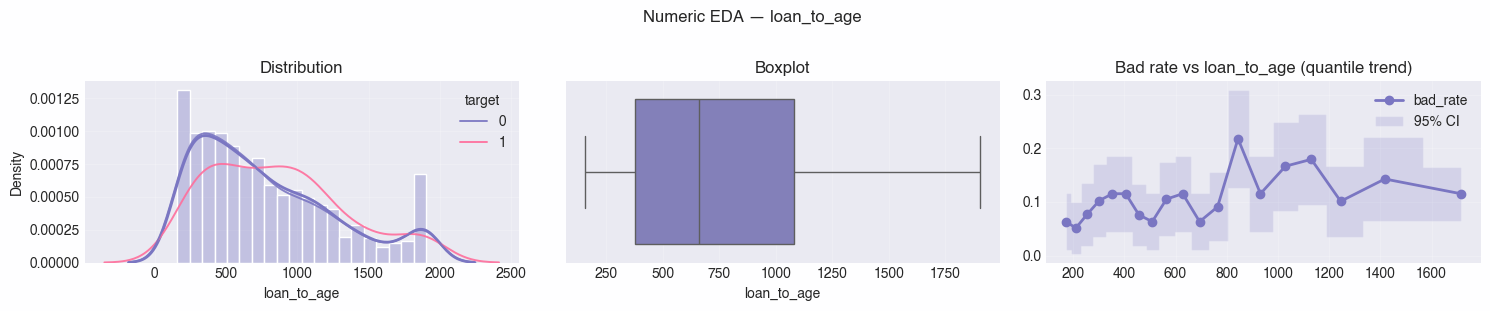

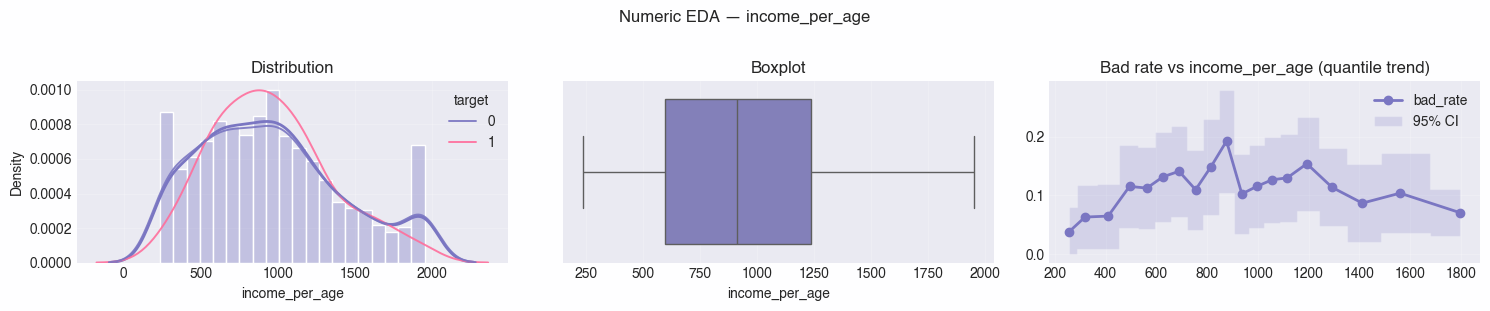

In [39]:
plot_numeric_eda(df_train, ["monthly_payment", "debt_to_income", "payment_to_income", "loan_to_age", "income_per_age"])

**Выводы**
1. Проблемы решины
2. Необходимо проверить на стабильность все фичи после преобразований

In [40]:
# Aggregate statistics
psi_matrix = get_psi_matrix(df_train, n_bins=10)
psi_max = psi_matrix.max(axis=0).rename("PSI_max")
psi_mean = psi_matrix.mean(axis=0).rename("PSI_mean")

# Summary table
psi_summary = pd.concat([psi_max, psi_mean], axis=1).sort_values("PSI_max", ascending=False)

# Flag features with high PSI (commonly ≥ 0.25)
psi_summary["Flagged"] = psi_summary["PSI_max"] >= 0.25
psi_summary

,PSI_max,PSI_mean,Flagged
product,0.693873,0.124649,True
monthly_payment,0.204379,0.115546,False
loan_to_age,0.183236,0.096331,False
payment_to_income,0.181160,0.089762,False
income_per_age,0.144043,0.070821,False
education,0.141274,0.035377,False
is_bank_client,0.132447,0.020775,False
loan_amount,0.121135,0.070726,False
income,0.120000,0.070641,False
debt_to_income,0.109967,0.061448,False


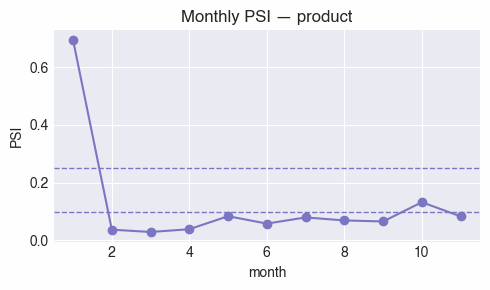

In [41]:
plot_unstable_features(psi_matrix, psi_summary)

**Выводы**
1. `product` стабилизируется после 2 месяца, в целом все ок

### WOE / IV (Weight of Evidence & Information Value)
- Преобразование признаков через биннинг (числовые → интервалы, категориальные → уровни)
- Расчет WOE: склонность бина к «хорошим» или «плохим» исходам
- Использование IV для оценки силы признака
    - < 0.02 - бесполезный
    - 0.02 – 0.10 - слабый
    - 0.10 – 0.30 - средний
    - 0.30 – 0.50 - сильный
    - \> 0.50 - слишком сильный (проверить на leakage)
- Обеспечение монотонности признаков (важно для скоринговых моделей)

In [42]:
# Config for OptimalBinning numeric WOE
@dataclass
class OBConfig:
    monotonic_trend: str = "auto"
    max_n_bins: int = 10
    min_bin_size: float = 0.05  # proportion
    solver: str = "cp"
    special_codes: list = field(default_factory=lambda: [np.nan])


In [43]:
# Build WOE/IV table for a categorical variable
def iv_table_categorical(df: pd.DataFrame, col: str, target: str = "target", eps=1e-9):
    g = df.groupby(col, dropna=False, observed=True)[target].agg(bad="sum", total="size")
    g["good"] = g["total"] - g["bad"]
    g = g[(g["bad"] >= 0) & (g["good"] >= 0)]

    bad_total = g["bad"].sum()
    good_total = g["good"].sum()

    g["bad_pct"] = g["bad"] / max(bad_total, eps)
    g["good_pct"] = g["good"] / max(good_total, eps)

    g["woe"] = np.log((g["good_pct"] + eps) / (g["bad_pct"] + eps))
    g["iv_bin"] = (g["good_pct"] - g["bad_pct"]) * g["woe"]
    iv_value = float(g["iv_bin"].sum())
    return iv_value, g


In [44]:
# sklearn-compatible transformer fits one OptimalBinning per numeric column using target
class NumericOptimalBinningWOE(BaseEstimator, TransformerMixin):

    def __init__(self, cols, config: OBConfig = None, suffix="_woe"):
        self.cols = cols
        self.config = config or OBConfig()
        self.suffix = suffix
        self.bins_ = {}
        self.iv_ = {}

    def fit(self, X: pd.DataFrame, y: pd.Series):
        # Ensure binary target 0/1
        y = pd.Series(y).astype(int).values
        for col in self.cols:
            x = pd.Series(X[col])
            ob = OptimalBinning(
                name=col, dtype="numerical",
                monotonic_trend=self.config.monotonic_trend,
                max_n_bins=self.config.max_n_bins,
                min_bin_size=self.config.min_bin_size,
                solver=self.config.solver,
                special_codes=self.config.special_codes,
            )
            ob.fit(x.values, y)
            self.bins_[col] = ob
            # IV from binning table
            bt = ob.binning_table.build()
            self.iv_[col] = float(bt["IV"].iloc[-1]) if "IV" in bt.columns else ob.status["iv"]
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        out = pd.DataFrame(index=X.index)
        for col, ob in self.bins_.items():
            w = ob.transform(X[col].values, metric="woe")
            out[f"{col}{self.suffix}"] = w
        return out


In [45]:
# Wrapper around category_encoders.WOEEncoder for selected categorical columns.
class CategoricalWOEEncoder(BaseEstimator, TransformerMixin):
    """WOE for categorical columns; also computes per-feature IV on TRAIN."""

    def __init__(self, cols, suffix="_woe", handle_missing="value", handle_unknown="value"):
        self.cols = cols
        self.suffix = suffix
        self.handle_missing = handle_missing
        self.handle_unknown = handle_unknown
        self.encoder_ = None
        self.iv_ = {}  # <- will be populated in fit

    def fit(self, X: pd.DataFrame, y):
        # Fit CE's WOE
        self.encoder_ = WOEEncoder(cols=self.cols,
                                   handle_missing=self.handle_missing,
                                   handle_unknown=self.handle_unknown)
        self.encoder_.fit(X[self.cols], y)
        # Compute IV on raw train
        df_tmp = X[self.cols].copy()
        df_tmp["__y__"] = pd.Series(y, index=X.index).astype(int)
        for c in self.cols:
            self.iv_[c], _ = iv_table_categorical(df_tmp[[c, "__y__"]].rename(columns={"__y__": "target"}), col=c)
        return self

    def transform(self, X: pd.DataFrame):
        enc = self.encoder_.transform(X[self.cols])
        enc.columns = [f"{c}{self.suffix}" for c in self.cols]
        enc.index = X.index
        return enc


In [46]:
# One-stop WOE encoder for mixed schema numeric via OptimalBinning -> WOE
class CombinedWOEEncoder(BaseEstimator, TransformerMixin):
    """
    Exposes iv_threshold and OB hyperparameters so GridSearchCV can tune them.
    """

    def __init__(self,
                 num_cols=None,
                 cat_cols=None,
                 iv_threshold: float = 0.0,
                 suffix: str = "_woe",
                 ob_monotonic_trend: str = "auto",
                 ob_max_n_bins: int = 8,
                 ob_min_bin_size: float = 0.02,
                 ob_solver: str = "cp",
                 ob_special_codes=None):
        self.num_cols = num_cols or []
        self.cat_cols = cat_cols or []
        self.iv_threshold = iv_threshold
        self.suffix = suffix
        self.ob_monotonic_trend = ob_monotonic_trend
        self.ob_max_n_bins = ob_max_n_bins
        self.ob_min_bin_size = ob_min_bin_size
        self.ob_solver = ob_solver
        self.ob_special_codes = [np.nan] if ob_special_codes is None else ob_special_codes

        self.num_enc_ = None
        self.cat_enc_ = None
        self.iv_numeric_ = {}
        self.iv_categorical_ = {}
        self.keep_cols_ = []
        self.keep_cols_woe_ = []
        self.feature_names_out_ = []

    def _ob_config(self) -> OBConfig:
        return OBConfig(
            monotonic_trend=self.ob_monotonic_trend,
            max_n_bins=self.ob_max_n_bins,
            min_bin_size=self.ob_min_bin_size,
            solver=self.ob_solver,
            special_codes=self.ob_special_codes
        )

    def fit(self, X: pd.DataFrame, y):
        if self.num_cols:
            self.num_enc_ = NumericOptimalBinningWOE(self.num_cols, self._ob_config(), self.suffix).fit(X, y)
            self.iv_numeric_ = self.num_enc_.iv_
        if self.cat_cols:
            self.cat_enc_ = CategoricalWOEEncoder(self.cat_cols, self.suffix).fit(X, y)
            self.iv_categorical_ = self.cat_enc_.iv_

        if self.iv_threshold > 0:
            iv_all = {**self.iv_numeric_, **self.iv_categorical_}
            self.keep_cols_ = [c for c, v in iv_all.items() if v >= self.iv_threshold]
        else:
            self.keep_cols_ = list(self.num_cols) + list(self.cat_cols)

        self.keep_cols_woe_ = [f"{c}{self.suffix}" for c in self.keep_cols_]
        self.feature_names_out_ = self.keep_cols_woe_
        return self

    def transform(self, X: pd.DataFrame):
        parts = []
        if self.num_enc_:
            parts.append(self.num_enc_.transform(X))
        if self.cat_enc_:
            parts.append(self.cat_enc_.transform(X))
        if not parts:
            return pd.DataFrame(index=X.index)
        Xt = pd.concat(parts, axis=1)
        if self.keep_cols_woe_:
            Xt = Xt.reindex(columns=self.keep_cols_woe_, fill_value=0.0)
        return Xt

    def get_feature_names_out(self):
        return list(self.feature_names_out_)

In [47]:
target_col = "target"
num_cols = df_train.select_dtypes(include=[np.number]).drop(columns=["target", "month"]).columns.tolist()
cat_cols = df_train.select_dtypes(include=["object", "category"]).columns.tolist()

woe = CombinedWOEEncoder(
    num_cols=num_cols,
    cat_cols=cat_cols
)

X_train = df_train[num_cols + cat_cols]
y_train = df_train[target_col].astype(int)

# Fit on train only
woe.fit(X_train, y_train)

# WOE features (train / OOT)
X_train_woe = woe.transform(X_train)
X_oot_woe = woe.transform(df_oot[num_cols + cat_cols])

X_train_woe


,loan_amount_woe,loan_term_woe,age_woe,income_woe,monthly_payment_woe,debt_to_income_woe,payment_to_income_woe,loan_to_age_woe,income_per_age_woe,gender_woe,education_woe,product_woe,children_woe,region_woe,marital_status_woe,is_bank_client_woe,region | mobile_operator_woe
0,0.047225,-0.293273,0.225443,-0.194283,0.012484,0.357762,0.404549,0.460970,-0.144006,-0.264882,0.208888,0.853887,0.185932,0.052445,-0.126453,-0.490179,0.204892
1,0.106867,0.317538,-0.282494,-0.047235,0.012484,0.064089,0.404549,-0.320257,-0.181468,-0.264882,-0.649568,-0.561151,0.185932,0.052445,-0.126453,0.243057,-0.308134
2,0.623705,0.581213,0.225443,-0.047235,-0.116211,0.357762,-0.228413,1.642274,-0.144006,0.257078,0.208888,-0.118940,-0.296613,0.052445,-0.126453,0.243057,0.173901
3,0.106867,-0.293273,-0.282494,-0.047235,-0.116211,0.064089,-0.228413,0.145979,-0.181468,-0.264882,0.208888,-1.210632,0.185932,0.052445,-0.126453,0.243057,0.204892
4,-0.224855,-0.293273,-0.022923,-0.047235,-0.116211,-0.270438,-0.228413,-0.320257,-0.181468,-0.264882,-0.649568,-0.969844,-0.296613,0.052445,-0.126453,0.243057,0.204892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,0.106867,-0.293273,-0.022923,0.958606,-0.116211,0.064089,0.000219,0.145979,0.149008,0.257078,0.208888,-0.561151,-0.296613,0.052445,-0.126453,0.243057,0.204892
1557,0.106867,0.581213,0.225443,-0.047235,-0.116211,0.064089,0.155896,0.157318,0.612655,-0.264882,-0.649568,-1.210632,-0.296613,0.052445,-0.126453,-0.490179,0.173901
1558,-0.115584,-0.293273,-0.022923,0.958606,-0.116211,0.064089,-0.228413,-0.320257,0.149008,0.257078,0.651444,-0.561151,0.185932,-0.178540,-0.126453,-0.490179,0.192641
1559,-0.224855,0.317538,-0.282494,0.958606,-0.116211,-0.270438,0.000219,-0.320257,0.149008,0.257078,-0.649568,0.139295,0.185932,0.052445,-0.126453,0.243057,-0.308134


In [48]:
# Single numeric variable binning report
col = "debt_to_income"
bt = woe.num_enc_.bins_[col].binning_table.build()
bt

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.36)",202,0.129404,186,16,0.079208,0.357762,0.014398,0.001790
1,"[0.36, 0.44)",112,0.071749,108,4,0.035714,1.200441,0.065191,0.007692
2,"[0.44, 0.81)",522,0.334401,468,54,0.103448,0.064089,0.001340,0.000167
3,"[0.81, 0.95)",156,0.099936,138,18,0.115385,-0.058514,0.000350,0.000044
4,"[0.95, inf)",569,0.364510,490,79,0.138840,-0.270438,0.029605,0.003689
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1561,1.000000,1390,171,0.109545,,0.110884,0.013383


**Выводы**
1. Информативность: признак умеренно предсказателен — IV 0.11 (диапазон 0.1–0.3 → средняя сила)

In [49]:
# All numeric IV as a Series
iv_numeric = pd.Series(woe.iv_numeric_, name="IV")
print(iv_numeric.sort_values(ascending=False))


loan_term            0.273299
income_per_age       0.258225
age                  0.225722
loan_to_age          0.151042
payment_to_income    0.132615
monthly_payment      0.120624
debt_to_income       0.110884
income               0.076837
loan_amount          0.050920
Name: IV, dtype: float64


In [50]:
iv_prod, tbl_prod = iv_table_categorical(df_train, "product", target_col)
print(f"IV product: {iv_prod}")
tbl_prod

IV product: 0.57542361362981


,bad,total,good,bad_pct,good_pct,woe,iv_bin
product,,,,,,,
Строительство,4,32,28,0.023392,0.020144,-0.149485,0.000486
Мода и уход,15,159,144,0.087719,0.103597,0.166368,0.002642
Дом и мебель,8,198,190,0.046784,0.136691,1.072187,0.096397
Авто и мото,3,30,27,0.017544,0.019424,0.101829,0.000191
Электроника,38,587,549,0.222222,0.394964,0.575117,0.099347
Мобильные телефоны,100,445,345,0.584795,0.248201,-0.857021,0.288468
Другое,3,110,107,0.017544,0.076978,1.478821,0.087893


**Выводы**
1. Сила признака: IV = 0.575 - сильный предиктор, кореляция с таргетов высокая, но data leakege нет, логично с точки зрения бизнеса
2. Профиль риска по реальным группам:
    - Мобильные теленфоны, Строительство имеют отрицательный WOE - риск выше среднего
    - Дом и мебель, Электроника, Авто и мото, и др — положительный WOE - ниже риск

In [51]:
# Merge numeric + categorical IV
iv_cat = pd.Series({c: iv_table_categorical(df_train, c, target_col)[0] for c in cat_cols}, name="IV")
iv_all = pd.concat([iv_numeric, iv_cat]).sort_values(ascending=False)
print(iv_all)

product                     0.575424
loan_term                   0.273299
income_per_age              0.258225
education                   0.235160
age                         0.225722
loan_to_age                 0.151042
payment_to_income           0.132615
is_bank_client              0.122398
monthly_payment             0.120624
debt_to_income              0.110884
income                      0.076837
region | mobile_operator    0.068711
gender                      0.068691
children                    0.056828
loan_amount                 0.050920
marital_status              0.033563
region                      0.020671
Name: IV, dtype: float64


**Выводы**
1. Сильные / топ-предикторы по IV product (0.57), loan_term (0.27), income_per_age (0.25), education (0.223), age (0.225)
2. Уверенные средние is_bank_client (0.122), loan_to_age (0.151), payment_to_income (0.132), debt_to_income (0.111), monthly_payment (0.121)
3. Пограничные, но прошли порог loan_amount (0.05), gender (0.068), children (0.056), region (0.073), region | mobile_operator (0.0687), income (0.077)

### Baseline Logistic Regression + Rolling CV

- Быстрый бенчмарк качества и стабильности
- Сплиты: time-based rolling CV (train < m, valid m) OOT — последние N месяцев, без стратификации.
- Подготовка: WOE (numeric — OptimalBinning, categorical — CE.WOEEncoder) -> отбор по IV (≥0.06) + фильтр стабильности (PSI_max < 0.25).
- LogisticRegression (class_weight='balanced'), баланс только на train.

In [52]:
class TQDMRandomizedSearchCV(RandomizedSearchCV):
    def _run_search(self, evaluate_candidates):
        sampler = list(ParameterSampler(self.param_distributions,self.n_iter, random_state=42))
        with tqdm(total=len(sampler), desc="RandomizedSearchCV", leave=True) as pbar:
            for params in sampler:
                evaluate_candidates([params])
                pbar.update(1)


In [53]:
# Pipeline
target_col = "target"
num_cols = df_train.select_dtypes(include=[np.number]).drop(columns=["target", "month"]).columns.tolist()
cat_cols = df_train.select_dtypes(include=["object", "category"]).columns.tolist()

pipe = ImbPipeline(steps=[
    ("woe", CombinedWOEEncoder(num_cols=num_cols, cat_cols=cat_cols)),
    ("ros", RandomOverSampler(random_state=42)),
    ("clf", LogisticRegression(solver="liblinear", penalty="l2" ,n_jobs=1, random_state=42)),
])


In [54]:
# Rolling CV splits (train df only)
cv_splits = [(tr, va) for (tr, va, *_) in list(month_rolling_splits(df_train))]

# GridSearch over rolling splits
X_tr = df_train[num_cols + cat_cols]
y_tr = df_train[target_col].astype(int)


In [55]:
def _proba_of(estimator, X, label):
    proba = estimator.predict_proba(X)
    idx = list(estimator.classes_).index(label)
    return proba[:, idx]


def auc_scorer(estimator, X, y, *, pos_label=1, **_):
    s = _proba_of(estimator, X, pos_label)
    return roc_auc_score(y, s)


def gini_scorer(estimator, X, y, *, pos_label=1, **_):
    s = _proba_of(estimator, X, pos_label)
    return 2 * roc_auc_score(y, s) - 1


def log_loss_scorer(estimator, X, y, *, pos_label=1, **_):
    s = _proba_of(estimator, X, pos_label)
    return log_loss(y, s)


def pr_scorer(estimator, X, y, *, pos_label=1, **_):
    s = _proba_of(estimator, X, pos_label)
    return average_precision_score(y, s, pos_label=pos_label)


def brier_scorer(estimator, X, y, *, pos_label=1, **_):
    s = _proba_of(estimator, X, pos_label)
    return -brier_score_loss(y, s, pos_label=pos_label)


def ks_scorer(estimator, X, y, *, pos_label=1, **_):
    s = _proba_of(estimator, X, pos_label)
    fpr, tpr, _ = roc_curve(y, s, pos_label=pos_label)
    return float(np.max(tpr - fpr))

scoring = {
    "gini": gini_scorer,
    "auc": auc_scorer,
    "log_loss": log_loss_scorer,
    "pr_auc": pr_scorer,
    "ks": ks_scorer,
    "brier": brier_scorer,
}

In [56]:
# Param grid (WOE + LR)
param_grid = {
    "woe__iv_threshold": [0.04, 0.06, 0.08],
    "woe__ob_max_n_bins": [5, 6, 8, 10],
    "woe__ob_min_bin_size": [0.05, 0.07, 0.09],
    "ros__sampling_strategy": [0.35, 0.5],
    "clf__C": [0.01, 0.1],
    "clf__max_iter": [500, 1000, 2000],
}

gs = TQDMRandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter = 400,
    cv=cv_splits,
    scoring=scoring,
    refit="auc",
    n_jobs=1,
    verbose=0,
    random_state=42,
)

with joblib.parallel_backend("threading"):
    gs.fit(X_tr, y_tr)

print("Best AUC (CV):", gs.best_score_)
print("Best params:", gs.best_params_)

RandomizedSearchCV:   0%|          | 0/400 [00:00<?, ?it/s]

Best AUC (CV): 0.7344124265142308
Best params: {'woe__ob_min_bin_size': 0.07, 'woe__ob_max_n_bins': 10, 'woe__iv_threshold': 0.04, 'ros__sampling_strategy': 0.5, 'clf__max_iter': 500, 'clf__C': 0.01}


In [76]:
best = pd.DataFrame(gs.cv_results_).iloc[gs.best_index_]

rows = []
for i in range(len(cv_splits)):
    rows.append({
        "fold": i,
        "gini": best[f"split{i}_test_gini"].round(5),
        "auc": best[f"split{i}_test_auc"].round(5),
        "log_loss": best[f"split{i}_test_log_loss"].round(5),
        "pr_auc": best[f"split{i}_test_pr_auc"].round(5),
        "ks": best[f"split{i}_test_ks"].round(5),
        "brier": -best[f"split{i}_test_brier"].round(5),
    })

fold_metrics = pd.DataFrame(rows)
print(f"Mean Gini: {fold_metrics["gini"].mean():.3f}, Std: {fold_metrics["gini"].std():.3f}")
print(f"Mean KS  : {fold_metrics["ks"].mean():.3f}, Std: {fold_metrics["ks"].std():.3f}")
fold_metrics


Mean Gini: 0.469, Std: 0.102
Mean KS  : 0.435, Std: 0.075


,fold,gini,auc,log_loss,pr_auc,ks,brier
0,0,0.49216,0.74608,0.50622,0.38652,0.41822,0.16261
1,1,0.36640,0.68320,0.45903,0.31261,0.34921,0.14207
2,2,0.35784,0.67892,0.43631,0.19642,0.34886,0.13157
3,3,0.61111,0.80556,0.43475,0.46610,0.48835,0.13246
4,4,0.40463,0.70231,0.42396,0.18714,0.44403,0.13013
5,5,0.58865,0.79432,0.42634,0.33603,0.56067,0.12875
6,6,0.46098,0.73049,0.45528,0.27028,0.43737,0.14209


**Выводы**

1. **Стабильность средняя:** AUC = **0.68–0.81**, среднее **0.735**; лучшие фолды — **3 и 5**, слабые — **1 и 2**
2. **KS согласован с AUC:** где AUC выше, там выше и KS -> ранжирование работает стабильно
3. **PR-AUC колеблется сильнее при стабильном Brier** -> вероятности калиброваны ок, но хвост чувствителен к сезонности/сдвигам


In [58]:
# Inspect selected features (by WOE) in the best pipeline
best_woe = gs.best_estimator_.named_steps["woe"]
print("Kept WOE features:", ', '.join(best_woe.get_feature_names_out()))


Kept WOE features: loan_amount_woe, loan_term_woe, age_woe, income_woe, monthly_payment_woe, debt_to_income_woe, payment_to_income_woe, loan_to_age_woe, income_per_age_woe, gender_woe, education_woe, product_woe, children_woe, is_bank_client_woe, region | mobile_operator_woe


In [59]:
# Inspect selected features (by IV) in the best pipeline
iv_num = pd.Series(best_woe.iv_numeric_, name="IV")
iv_cat = pd.Series(best_woe.iv_categorical_, name="IV")

iv_all = (
    pd.concat([
        iv_num.rename_axis("feature").reset_index().assign(type="numeric"),
        iv_cat.rename_axis("feature").reset_index().assign(type="categorical"),
    ], ignore_index=True)
    .sort_values("IV", ascending=False)[["feature", "type", "IV"]]
)

iv_kept = (
    iv_all[iv_all["feature"].isin({c.removesuffix("_woe") for c in list(best_woe.get_feature_names_out())})]
    .assign(woe_feature=lambda d: d["feature"])
    .sort_values("IV", ascending=False)
    [["woe_feature", "type", "IV"]]
)

iv_kept


,woe_feature,type,IV
11,product,categorical,0.575424
1,loan_term,numeric,0.259944
10,education,categorical,0.235160
2,age,numeric,0.168863
8,income_per_age,numeric,0.166035
15,is_bank_client,categorical,0.122398
7,loan_to_age,numeric,0.120843
4,monthly_payment,numeric,0.120624
6,payment_to_income,numeric,0.116419
5,debt_to_income,numeric,0.110884


In [60]:
def adjust_proba_for_oversampling(p, p_real, p_train):
    p = np.clip(p, 1e-9, 1 - 1e-9)
    logit_p = np.log(p / (1 - p))
    logit_corr = logit_p + (np.log(p_real / (1 - p_real)) - np.log(p_train / (1 - p_train)))
    p_corr = 1 / (1 + np.exp(-logit_corr))
    return p_corr

In [61]:
# Return predicted probabilities for the positive class
def proba_of(pipe, X, pos_label=1):
    proba = pipe.predict_proba(X)
    return proba[:, list(pipe.classes_).index(pos_label)]


In [62]:
# KS-optimal threshold for given labels and probabilities
def ks_threshold(y_true, p):
    fpr, tpr, thr = roc_curve(y_true, p)
    idx = int(np.argmax(tpr - fpr))
    t = thr[idx]
    if not np.isfinite(t):
        t = thr[idx + 1] if idx + 1 < len(thr) else thr[idx - 1]
    return float(np.clip(t, 0.0, 1.0))

In [77]:
# OOT evaluation
pipe = gs.best_estimator_
X_oot = df_oot[num_cols + cat_cols]
y_oot = df_oot[target_col].astype(int).values

r = gs.best_params_.get("ros__sampling_strategy")

pos_label = 1
y_oot_proba = adjust_proba_for_oversampling(
    p=_proba_of(pipe, X_oot, pos_label),
    p_real=y_tr.mean(),
    p_train=r / (1 + r)
)


auc = roc_auc_score(y_oot, y_oot_proba)
gini = 2 * auc - 1
loss = log_loss(y_oot, y_oot_proba)
pr = average_precision_score(y_oot, y_oot_proba, pos_label=pos_label)
brier = brier_score_loss(y_oot, y_oot_proba, pos_label=pos_label)
fpr, tpr, _ = roc_curve(y_oot, y_oot_proba)
ks = float(np.max(tpr - fpr))


In [79]:
# Compute KS threshold on CV
r = pipe.named_steps["ros"].sampling_strategy
p_train_cv = r / (1.0 + r)

cv_thresholds = []
y_val_all, p_val_all = [], []

for tr_idx, va_idx in cv_splits:
    p = clone(pipe)
    X_tr_f, y_tr_f = X_tr.iloc[tr_idx], y_tr.iloc[tr_idx]
    X_va_f, y_va_f = X_tr.iloc[va_idx], y_tr.iloc[va_idx]

    # fit on the fold's train
    p.fit(X_tr_f, y_tr_f)

    # probabilities on the fold's validation
    p_val = proba_of(p, X_va_f, pos_label)
    # prior correction (use fold's real base rate)
    p_real_fold = float(y_tr_f.mean())
    p_val = adjust_proba_for_oversampling(p_val, p_real_fold, p_train_cv)

    # KS-threshold for this fold
    t_fold = ks_threshold(y_va_f, p_val)
    cv_thresholds.append(t_fold)

    # accumulate to also compute a pooled KS threshold
    y_val_all.append(y_va_f.values)
    p_val_all.append(p_val)

# Pooled KS threshold across all validation predictions
y_val_all = np.concatenate(y_val_all)
p_val_all = np.concatenate(p_val_all)
t_ks_pooled = ks_threshold(y_val_all, p_val_all)


print(f"OOT \n"
      f"Gini     = {gini:.4f}\n"
      f"AUC      = {auc:.4f}\n"
      f"Log loss = {loss:.4f}\n"
      f"PR-AUC   = {pr:.4f}\n"
      f"KS       = {ks:.4f}\n"
      f"Brier    = {brier:.4f}\n")

print(f"KS threshold (pooled CV preds):  {t_ks_pooled:.4f}\n")
print(classification_report(y_oot, (y_oot_proba >= t_ks_pooled).astype(int)))


OOT 
Gini     = 0.4581
AUC      = 0.7291
Log loss = 0.3938
PR-AUC   = 0.3269
KS       = 0.4242
Brier    = 0.1221

KS threshold (pooled CV preds):  0.1246

              precision    recall  f1-score   support

           0       0.92      0.69      0.79       137
           1       0.28      0.68      0.40        25

    accuracy                           0.69       162
   macro avg       0.60      0.68      0.59       162
weighted avg       0.82      0.69      0.73       162



**Выводы**
1. Разделимость: AUC = 0.729, KS = 0.424 — сопоставимо со средним CV (AUC = 0.735, KS = 0.435) -> генерализация нормальная
2. Калибровка: Brier = 0.122 и LogLoss = 0.394 — на уровне/лучше CV ->  PD откалиброваны -> OOF Isotonic с фоллбеком на Platt для доведения PD
3. Порог: KS по pooled-CV дал t = 0.1246 -> на OOT: precision(1)=0.28, recall(1)=0.68, F1=0.40 -> режим "максимальный захват"

### Calibration (OOF Isotonic → Platt fallback)

* Выровнять PD с фактами, снизить **Brier/LogLoss** (AUC/KS без изменений).
* Собрать **OOF** калиброванные PD -> обучить глобальный калибратор
* Подбирать на калиброванных PD


In [80]:
# Calibrator that tries Isotonic first, falls back to Platt (sigmoid)
class IsotonicOrPlatt:
    def __init__(self, min_unique=30):
        self.min_unique = int(min_unique)
        self.kind = None
        self.model = None

    def fit(self, y, p):
        y = np.asarray(y).astype(int)
        p = np.asarray(p).astype(float)
        # basic sanity checks
        has_both_classes = (y.min() != y.max())
        enough_unique = (np.unique(p).size >= self.min_unique)
        try_iso = has_both_classes and enough_unique

        if try_iso:
            try:
                self.model = IsotonicRegression(out_of_bounds="clip")
                self.model.fit(p, y)
                self.kind = "isotonic"
                return self
            except Exception:
                pass  # fall back to Platt

        # Platt: logistic regression on the raw scores
        self.model = LogisticRegression(
            solver="lbfgs", C=1e6, max_iter=2000, n_jobs=1, penalty="l2"
        )
        self.model.fit(p.reshape(-1, 1), y)
        self.kind = "platt"
        return self

    def predict(self, p):
        p = np.asarray(p).astype(float)
        if self.kind == "isotonic":
            return self.model.predict(p)
        return self.model.predict_proba(p.reshape(-1, 1))[:, 1]


In [81]:
#proto = pipe with best params (unfitted)
proto = clone(pipe).set_params(**gs.best_params_)
r = proto.named_steps["ros"].sampling_strategy
p_train = float(r) / (1.0 + float(r))

# OOF calibration
oof_cal = np.zeros(len(y_tr), dtype=float)
for tr_idx, va_idx in cv_splits:
    m = clone(proto).fit(X_tr.iloc[tr_idx], y_tr.iloc[tr_idx])
    p_va = proba_of(m, X_tr.iloc[va_idx], pos_label)
    p_va = adjust_proba_for_oversampling(p_va, float(y_tr.iloc[tr_idx].mean()), p_train)
    cal = IsotonicOrPlatt(min_unique=30).fit(y_tr.iloc[va_idx], p_va)
    oof_cal[va_idx] = cal.predict(p_va)


In [82]:
# global calibrator on OOF
global_cal = IsotonicOrPlatt(min_unique=50).fit(y_tr, oof_cal)

# final model (use refitted GS if available)
final_model = gs.best_estimator_ if getattr(gs, "refit", False) else clone(proto).fit(X_tr, y_tr)

# calibrated OOT probabilities
p_oot = proba_of(final_model, X_oot, pos_label)
p_oot = adjust_proba_for_oversampling(p_oot, float(y_tr.mean()), p_train)
p_oot_cal = global_cal.predict(p_oot)

In [83]:
# metrics + KS-threshold report
auc   = roc_auc_score(y_oot, p_oot_cal)
gini = 2 * auc - 1
loss = log_loss(y_oot, p_oot_cal)
pr    = average_precision_score(y_oot, p_oot_cal)
brier = brier_score_loss(y_oot, p_oot_cal)
fpr, tpr, thr = roc_curve(y_oot, p_oot_cal)
ks = float(np.max(tpr - fpr))
t_ks = float(np.clip(thr[int(np.argmax(tpr - fpr))], 0.0, 1.0))

print(f"Calibrated OOT \n"
      f"Gini     = {gini:.4f}\n"
      f"AUC      = {auc:.4f}\n"
      f"Log loss = {loss:.4f}\n"
      f"PR-AUC   = {pr:.4f}\n"
      f"KS       = {ks:.4f}\n"
      f"Brier    = {brier:.4f}\n")

print(classification_report(y_oot, (p_oot_cal >= t_ks).astype(int)))

Calibrated OOT 
Gini     = 0.4581
AUC      = 0.7291
Log loss = 0.4032
PR-AUC   = 0.3269
KS       = 0.4242
Brier    = 0.1235

              precision    recall  f1-score   support

           0       0.94      0.66      0.78       137
           1       0.29      0.76      0.42        25

    accuracy                           0.68       162
   macro avg       0.62      0.71      0.60       162
weighted avg       0.84      0.68      0.72       162



**Выводы**
1. Разделимость: AUC = 0.729, KS = 0.424 — сопоставимо со средним CV -> генерализация нормальная
2. Калибровка: Brier = 0.123, LogLoss = 0.403 — калибровка ок
3. Режим выбранного порога: для класса 1 precision 0.29, recall 0.76, F1 = 0.42 -> высокий захват. По отрицательному классу recall = 0.66 -> FPR = 0.34

In [84]:
# raw -> prior-fix -> calibrated
p_oot_raw   = proba_of(final_model, X_oot, pos_label)
p_oot_prior = adjust_proba_for_oversampling(p_oot_raw, float(y_tr.mean()), float(p_train))
p_oot_cal   = global_cal.predict(p_oot_prior)

In [85]:
def ks_stat(y, p):
    fpr, tpr, _ = roc_curve(y, p)
    return float(np.max(tpr - fpr))

stages = ["raw", "prior", "calibrated"]
probs  = [p_oot_raw, p_oot_prior, p_oot_cal]
rows = []
for name, p in zip(stages, probs):
    rows.append({
        "stage": name,
        "Gini": 2 * roc_auc_score(y_oot, p) - 1,
        "ROC AUC": roc_auc_score(y_oot, p),
        "PR AUC": average_precision_score(y_oot, p),
        "KS": ks_stat(y_oot, p),
        "Brier": brier_score_loss(y_oot, p),
    })

df_metrics = (pd.DataFrame(rows)
                .set_index("stage")
                .loc[stages, ["Gini", "ROC AUC", "PR AUC", "KS", "Brier"]]
                .round(4))

df_metrics

,Gini,ROC AUC,PR AUC,KS,Brier
stage,,,,,
raw,0.4581,0.7291,0.3269,0.4242,0.1516
prior,0.4581,0.7291,0.3269,0.4242,0.1221
calibrated,0.4581,0.7291,0.3269,0.4242,0.1235


### Dump model

In [86]:
# Save for production
joblib.dump(final_model, "model_raw.pkl")        # pipe with best params, fitted
joblib.dump(global_cal, "prob_calibrator.pkl")   # isotonic -> platt
joblib.dump({"p_real_train": float(y_tr.mean()),
             "p_train_ros":  float(p_train),
             "pos_label":    int(pos_label)}, "prior_params.pkl")


['prior_params.pkl']

In [87]:
# Inference example
# model = joblib.load("model_raw.pkl")
# calibrator = joblib.load("prob_calibrator.pkl")
# prior_params = joblib.load("prior_params.pkl")
# y_raw = proba_of(model, X_new, prior_params["pos_label"])
# y_prior = adjust_proba_for_oversampling(y_raw, prior_params["p_real_train"], prior_params["p_train_ros"])
# y_cal = calibrator.predict(y_prior)
